In [108]:
import argparse
import os
import random
import time
import math

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# dataframes
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
# from PIL import Image
# import matplotlib.animation as animation
# from IPython.display import HTML

# signal processing
from scipy import signal
# import pywt

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [49]:
import socket
myHostName = socket.gethostname()
print(myHostName)

wifi-staff-172-24-15-10.net.auckland.ac.nz


In [50]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 300

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.00002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# type of gan
gans_type = "dcgans"

### Dataloader

Getting parameters such as data mean and sd for standardisation

In [51]:
gw_df = pd.read_csv('../data/gw-raw-data/richers_1764.csv')

# probability of augmenting data
aug_p = 0.5

# y-axis processing
# distance = 3.086e22
# gw_df = gw_df / distance

gw_mean = gw_df.mean().mean()
print('Dataset mean: ',  gw_mean)

gw_std = gw_df.std().mean()
print('Dataset std: ',  gw_std)

gw_scaling_factor = 5
print('Dataset scaling factor (to match noise in generator): ',  gw_scaling_factor)

Dataset mean:  -0.04824243411562023
Dataset std:  28.792067898778328
Dataset scaling factor (to match noise in generator):  5


279
319
80
320
360
80
316
356
80
269
309
80
306
346
80
241
281
80
190
230
80
223
263
80
195
235
80
303
343
80
240
280
80
254
294
80
290
330
80
257
297
80
191
231
80
256
296
80
278
318
80
309
349
80
267
307
80
319
359
80
204
244
80
296
336
80
214
254
80
302
342
80
247
287
80
255
295
80
183
223
80
233
273
80
314
354
80
207
247
80
238
278
80
299
339
80
242
282
80
326
366
80
191
231
80
276
316
80
215
255
80
181
221
80
206
246
80
293
333
80
303
343
80
214
254
80
319
359
80
202
242
80
284
324
80
266
306
80
249
289
80
307
347
80
195
235
80
285
325
80
223
263
80
279
319
80
230
270
80
306
346
80
252
292
80
321
361
80
303
343
80
263
303
80
181
221
80
275
315
80
260
300
80
261
301
80
319
359
80
288
328
80
199
239
80
189
229
80
304
344
80
216
256
80
282
322
80
181
221
80
251
291
80
325
365
80
266
306
80
295
335
80
197
237
80
203
243
80
313
353
80
245
285
80
226
266
80
237
277
80
211
251
80
320
360
80
260
300
80
241
281
80
202
242
80
261
301
80
189
229
80
292
332
80
255
295
80
300
340
80
273
313
80

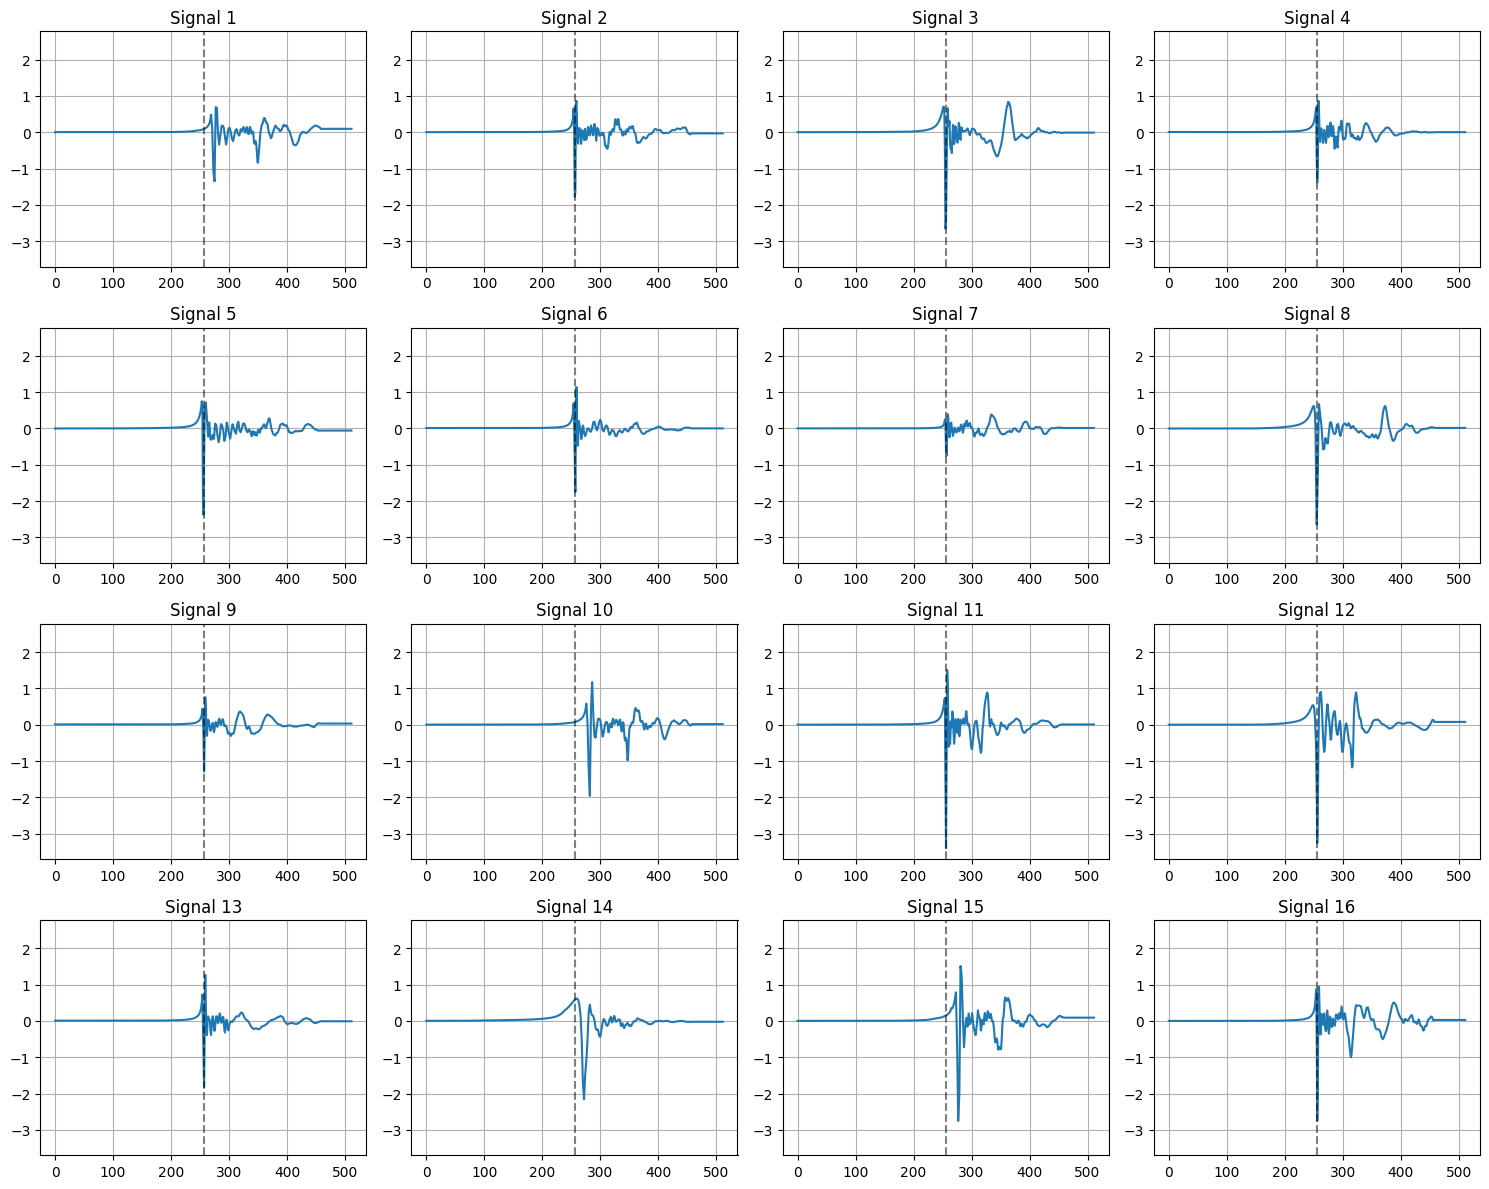

In [127]:
class GWDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file).astype('float32')
        self.data = self.data.values

    def calc_stats(self):
        self.mean = self.data.mean()
        print('Dataset mean: ',  self.mean)
        self.std = np.std(self.data, axis=None)
        print('Dataset std: ',  self.std)
        self.scaling_factor = 5
        print('Dataset scaling factor (to match noise in generator): ',  self.scaling_factor)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal

    # def pad_signals(self):
    #     desired_length = 512
    #     augmented_signals = np.empty((desired_length, self.data.shape[1]), dtype=int)

    #     for i in range(self.data.shape[1]):
    #         signal = self.data[:, i]
    #         signal = signal.reshape(1, -1)

    #         padding_left = (desired_length - len(signal[0])) // 2
    #         padding_right = desired_length - len(signal[0]) - padding_left

    #         signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

    #         augmented_signals = np.insert(augmented_signals, augmented_signals.shape[1], signal_padded, axis=1)

    #     self.data = augmented_signals
    
    def standardize(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal

    def shift_augmentation(self, signal):
        shift = np.random.normal(0, 50, 1)
        shifted_signal = np.roll(signal, int(shift))
        
        return shifted_signal

    def scale_augmentation(self, signal):
        scale_factor = np.random.normal(1, 0.2, 1)
        scale_factor = np.maximum(scale_factor, 0)
        scaled_signal = scale_factor * signal

        return scaled_signal

    def jittering_augmentation(self, signal):
        # todo: add noise only after time of core bounce
        # noise_start_time = 203

        # noise = np.random.normal(0, 0.05, signal.shape[1] - noise_start_time)
        # jittered_signal = signal[noise_start_time:] + noise
        noise = np.random.normal(0, 5, signal.shape[1])
        jittered_signal = signal + noise
    
        return jittered_signal

    def mixture_augmentation(self, signal_1, signal_2):
        distance_multiplier = np.random.normal(0.5, 0.2, 1)
        # clip signal to range [0,1] as this is the multiplier by the normalised difference in signals
        distance_multiplier = np.clip(distance_multiplier, 0, 1)
        mixture_signal = signal_1 + distance_multiplier * (signal_2 - signal_1)

        return mixture_signal

    def window_warping_augmentation(self, signal):
        # don't warp anything a little bit before the core-bounce
        window_min_idx = 180

        # take window size of 10% of the signal with a warping factor for 2 (from literature)
        window_size = math.floor(signal.shape[1] / 10)
        warping_factor = 2
        scaled_window_size = warping_factor * window_size

        # find random reference position for start of window warping
        window_start_idx = np.random.randint(window_min_idx, signal.shape[1] - scaled_window_size)
        window_end_idx = window_start_idx + window_size

        # extract values before, at and after the window
        # clip end of signal to make up for extra size due to window warping
        signal_before_window = signal[0][:window_start_idx]
        signal_window = signal[0][window_start_idx:window_end_idx]
        signal_after_window = signal[0][window_end_idx:int(signal.shape[1]-(window_size))]

        # time points
        t = np.arange(len(signal_window))
        warped_t = np.arange(0, len(signal_window), 0.5)

        # interpolation for window warping
        signal_window_warped = np.interp(warped_t, t, signal_window)

        # combine signals
        warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)

        return warped_signal

    def augmentation(self, desired_augmented_data_count):
        augmented_signals = self.data.copy()

        while augmented_signals.shape[1] < desired_augmented_data_count:
            idx_1 = np.random.randint(0, self.data.shape[1])
            signal_1 = self.data[:, idx_1]
            signal_1 = signal_1.reshape(1, -1)

            # second signal used only used for mixture signals data augmentation
            # idx_2 = np.random.randint(0, self.data.shape[1])
            idx_2 = np.random.choice([x for x in range(0, self.data.shape[1]) if x != idx_1])
            signal_2 = self.data[:, idx_2]
            signal_2 = signal_2.reshape(1, -1)

            # call selected augmentation function here
            augmented_signal = self.window_warping_augmentation(signal_1)

            augmented_signals = np.insert(augmented_signals, augmented_signals.shape[1], augmented_signal, axis=1)

        self.data = augmented_signals

    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        # process signal from strain * distance (10 kpc) -> just strain
        # distance = 3.086e22
        # signal = signal / distance

        # reshape signal to have first 512 - 407 values to be 0.
        desired_length = 512

        padding_left = (desired_length - len(signal[0])) // 2
        padding_right = desired_length - len(signal[0]) - padding_left

        signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

        signal_standardized = self.standardize(signal_padded)

        return signal_standardized

dataset = GWDataset("../data/gw-raw-data/richers_1764.csv")
common_ylim_signal = dataset.get_common()
# dataset.pad_signals()
dataset.augmentation(6000)
dataset.calc_stats()
# dataset.standardize()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

real_batch = next(iter(dataloader))

# Expecting: (32, 1, 512)
print(real_batch.shape)

common_ylim = (real_batch[:,:,:].min(), real_batch[:,:,:].max())

def plot_and_save_waveforms(real_batch, filename='waveforms.png'):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()
    
    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_batch.size(dim=2))
        y = real_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i+1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)
    
    for i in range(512, 8*4):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()

plot_and_save_waveforms(real_batch, filename='../data/gw-dcgans-plots/real_data.png')

In [53]:
dataset.__len__()

6000

### Weight Initialisation (Random Noise)

In [54]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [55]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose1d(nz, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(ngf * 64),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 64, ngf * 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 32),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 16),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 8),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 4),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 2),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, x):
        # print(x.shape)
        x = self.main(x)
        return x

In [56]:
# # Create the generator
netG = Generator().to(device)
netG.apply(weights_init)

print(netG)

model = Generator()
summary(model, input_size=(nz, 1))

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(300, 4096, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose1d(4096, 2048, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), b

### Discriminator

In [57]:
if (gans_type == "dcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),
                
                nn.Conv1d(ndf * 64, nc, kernel_size=4,
                        stride=2, padding=0, bias=False),
            )

            # fully conencted layer to output probability
            self.fc = nn.Sequential(
                nn.Dropout(0.25),
                nn.Sigmoid()
            )

        def forward(self, x, y=None):
            # print(x.shape)
            x = self.main(x)
            # print(x.shape)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            # print(x)
            return x

elif (gans_type == "wgans"):
    class Critic(nn.Module):
        def __init__(self):
            super(Critic, self).__init__()
            self.main = nn.Sequential(
                # xl kernel, stride and padding on this one (first layer group)
                nn.Conv1d(nc, ndf, kernel_size=8, stride=4, padding=2, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                # xl kernel, stride and padding on this one (last layer group)
                nn.Conv1d(ndf * 32, nc, kernel_size=8,
                        stride=4, padding=2, bias=False),
            )

        def forward(self, x, y=None):
            # print(x.shape)
            x = self.main(x)
            # print(x.shape)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            # x = self.fc(x)
            # print(x)
            return x

In [58]:
if (gans_type == "dcgans"):
    netD = Discriminator().to(device)
    netD.apply(weights_init)

    print(netD)

    model = Discriminator()
    summary(model, input_size=(1, 512))

elif (gans_type == "wgans"):
    netC = Critic().to(device)
    netC.apply(weights_init)

    print(netC)

    model = Critic()
    summary(model, input_size=(1, 512))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.25, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout(p=0.25, inp

### Loss functions and Optimisers

In [59]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

Starting Training Loop...
[0/20][0/188]	Loss_D: 2.0779	Loss_G: 0.7490	D(x): 0.3903	D(G(z)): 0.3985 / 0.3800
[0/20][50/188]	Loss_D: 1.1422	Loss_G: 2.5697	D(x): 0.1555	D(G(z)): 0.6630 / 0.7009
[0/20][100/188]	Loss_D: 1.0355	Loss_G: 2.0191	D(x): 0.1739	D(G(z)): 0.7437 / 0.6679
[0/20][150/188]	Loss_D: 0.9441	Loss_G: 2.1881	D(x): 0.2230	D(G(z)): 0.7104 / 0.7177


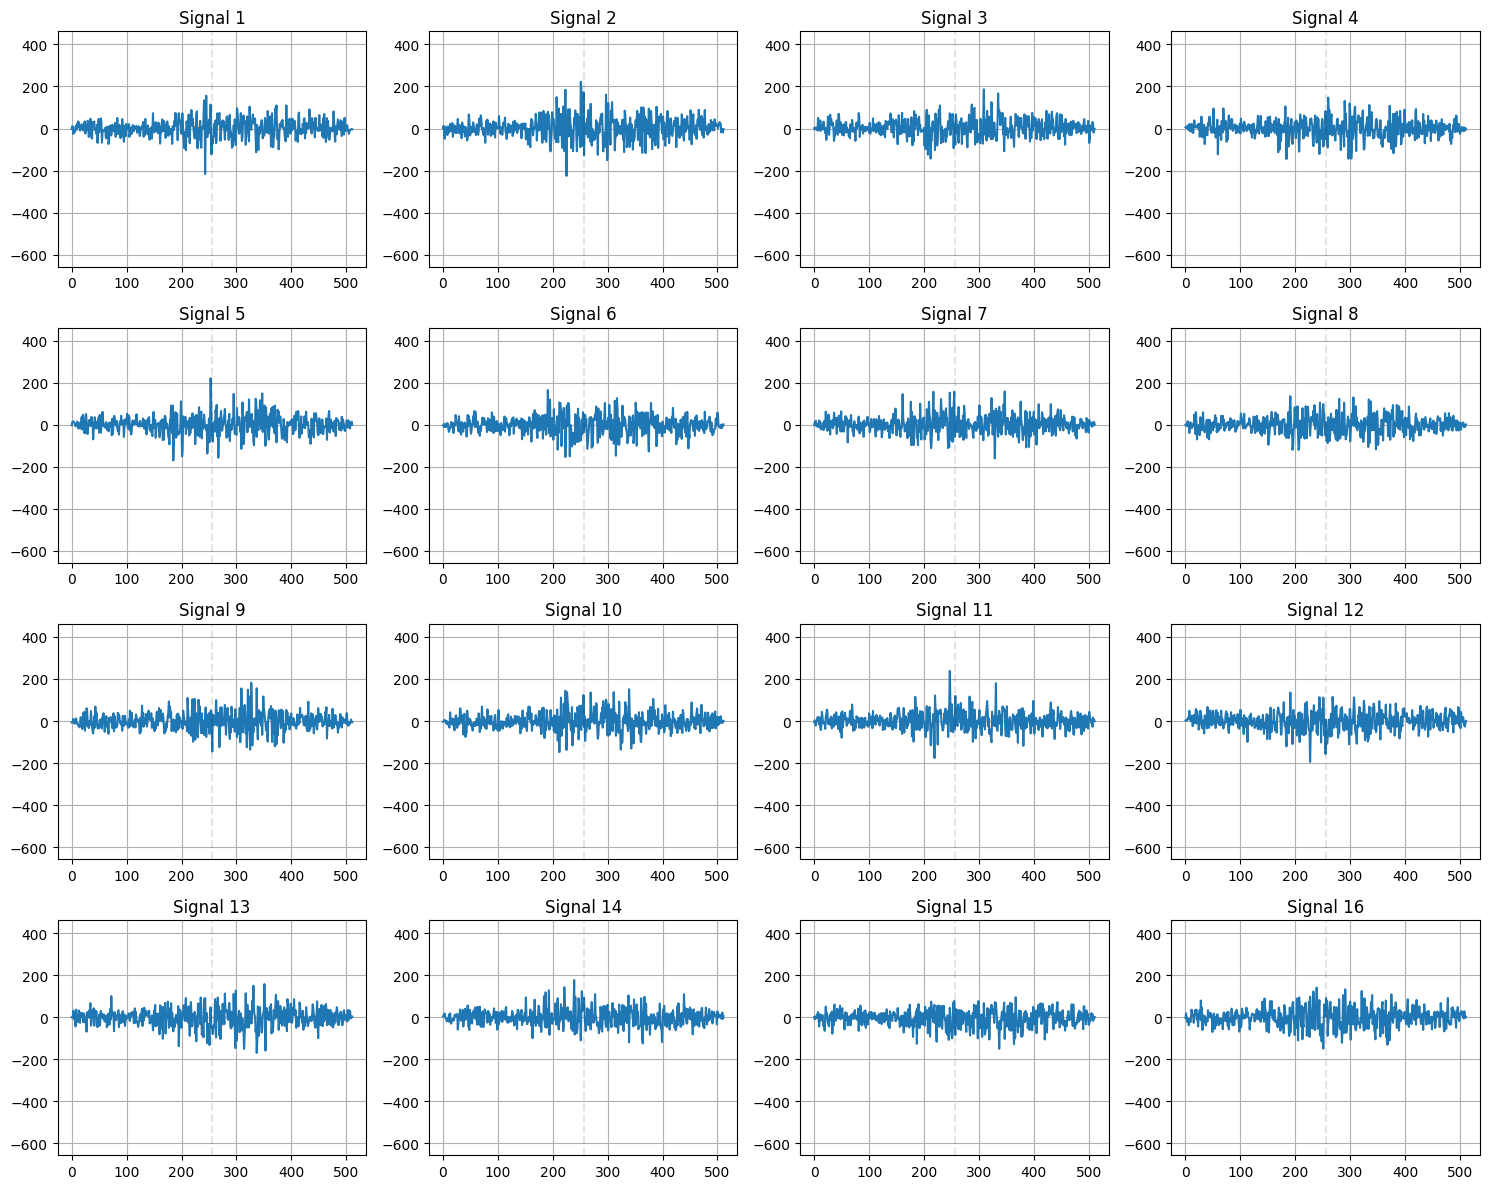

[1/20][0/188]	Loss_D: 0.9345	Loss_G: 2.1896	D(x): 0.1240	D(G(z)): 0.7036 / 0.7542
[1/20][50/188]	Loss_D: 1.0905	Loss_G: 2.8093	D(x): 0.2567	D(G(z)): 0.7858 / 0.7947
[1/20][100/188]	Loss_D: 1.2683	Loss_G: 2.2174	D(x): 0.1822	D(G(z)): 0.7261 / 0.6652
[1/20][150/188]	Loss_D: 0.5720	Loss_G: 2.1747	D(x): 0.1674	D(G(z)): 0.8014 / 0.6744


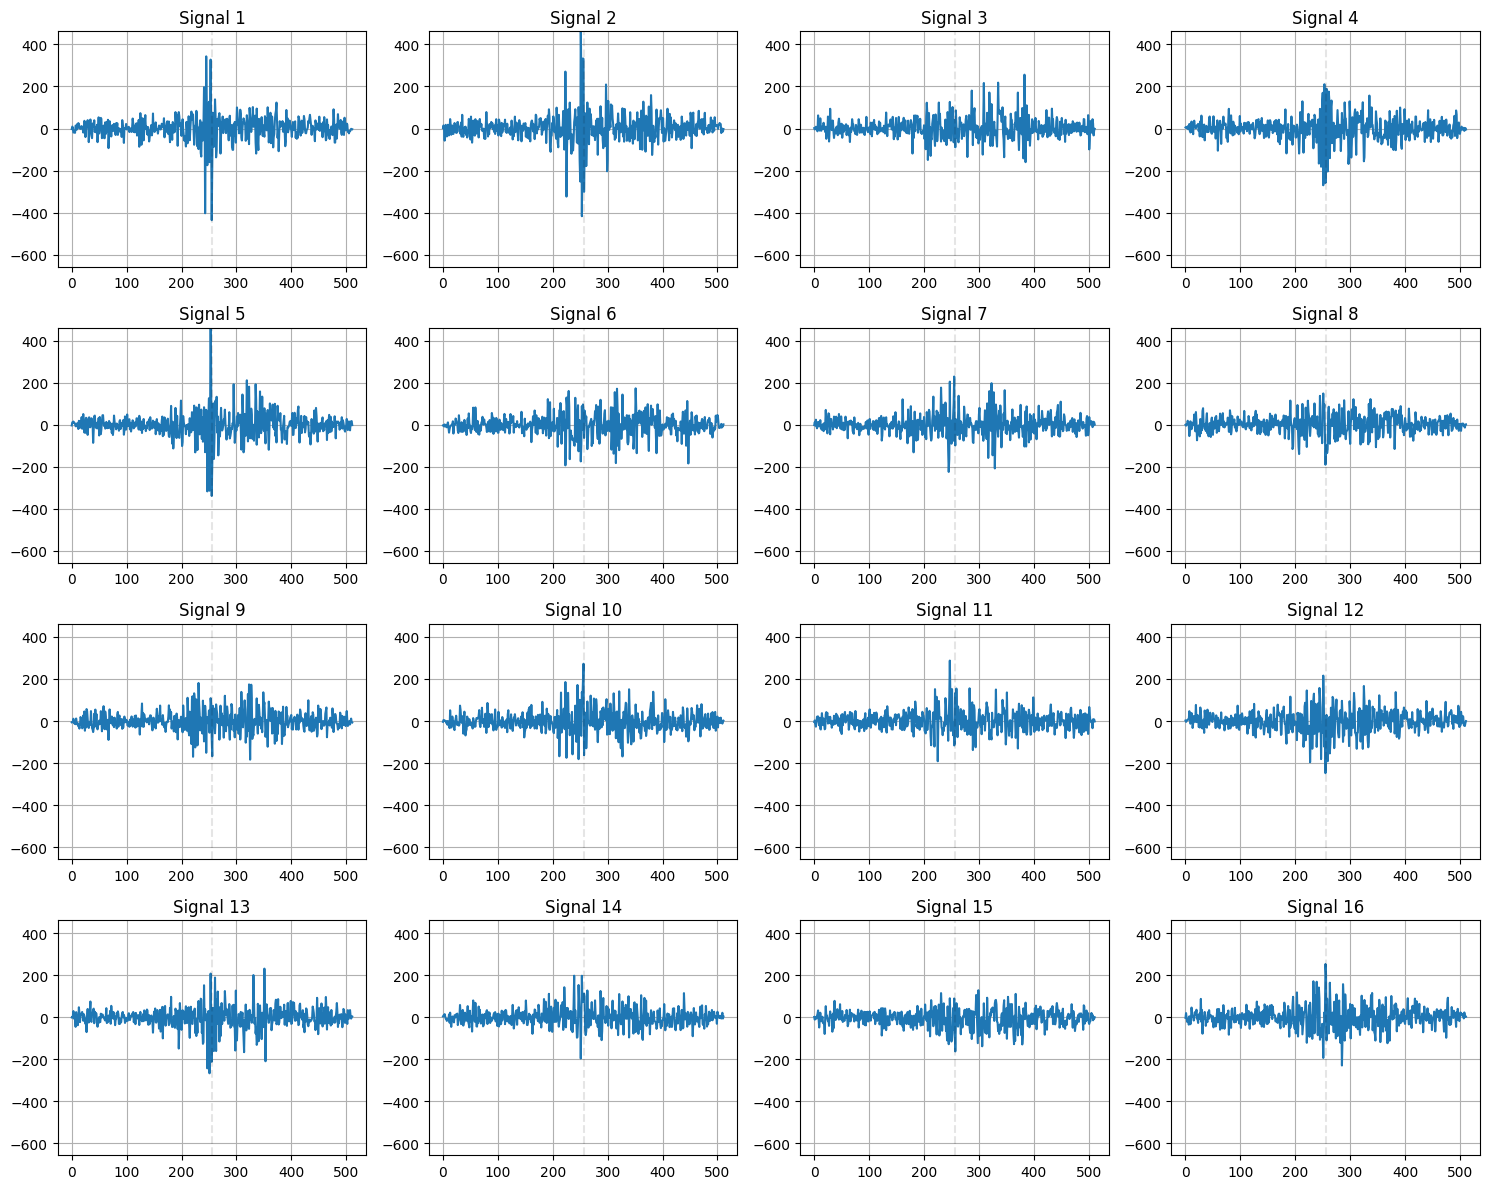

[2/20][0/188]	Loss_D: 1.0130	Loss_G: 2.8260	D(x): 0.1629	D(G(z)): 0.6717 / 0.8048
[2/20][50/188]	Loss_D: 0.8759	Loss_G: 2.5558	D(x): 0.1510	D(G(z)): 0.6856 / 0.6951
[2/20][100/188]	Loss_D: 1.1032	Loss_G: 2.9178	D(x): 0.1339	D(G(z)): 0.7189 / 0.7510
[2/20][150/188]	Loss_D: 0.8992	Loss_G: 2.3622	D(x): 0.2185	D(G(z)): 0.7649 / 0.7156


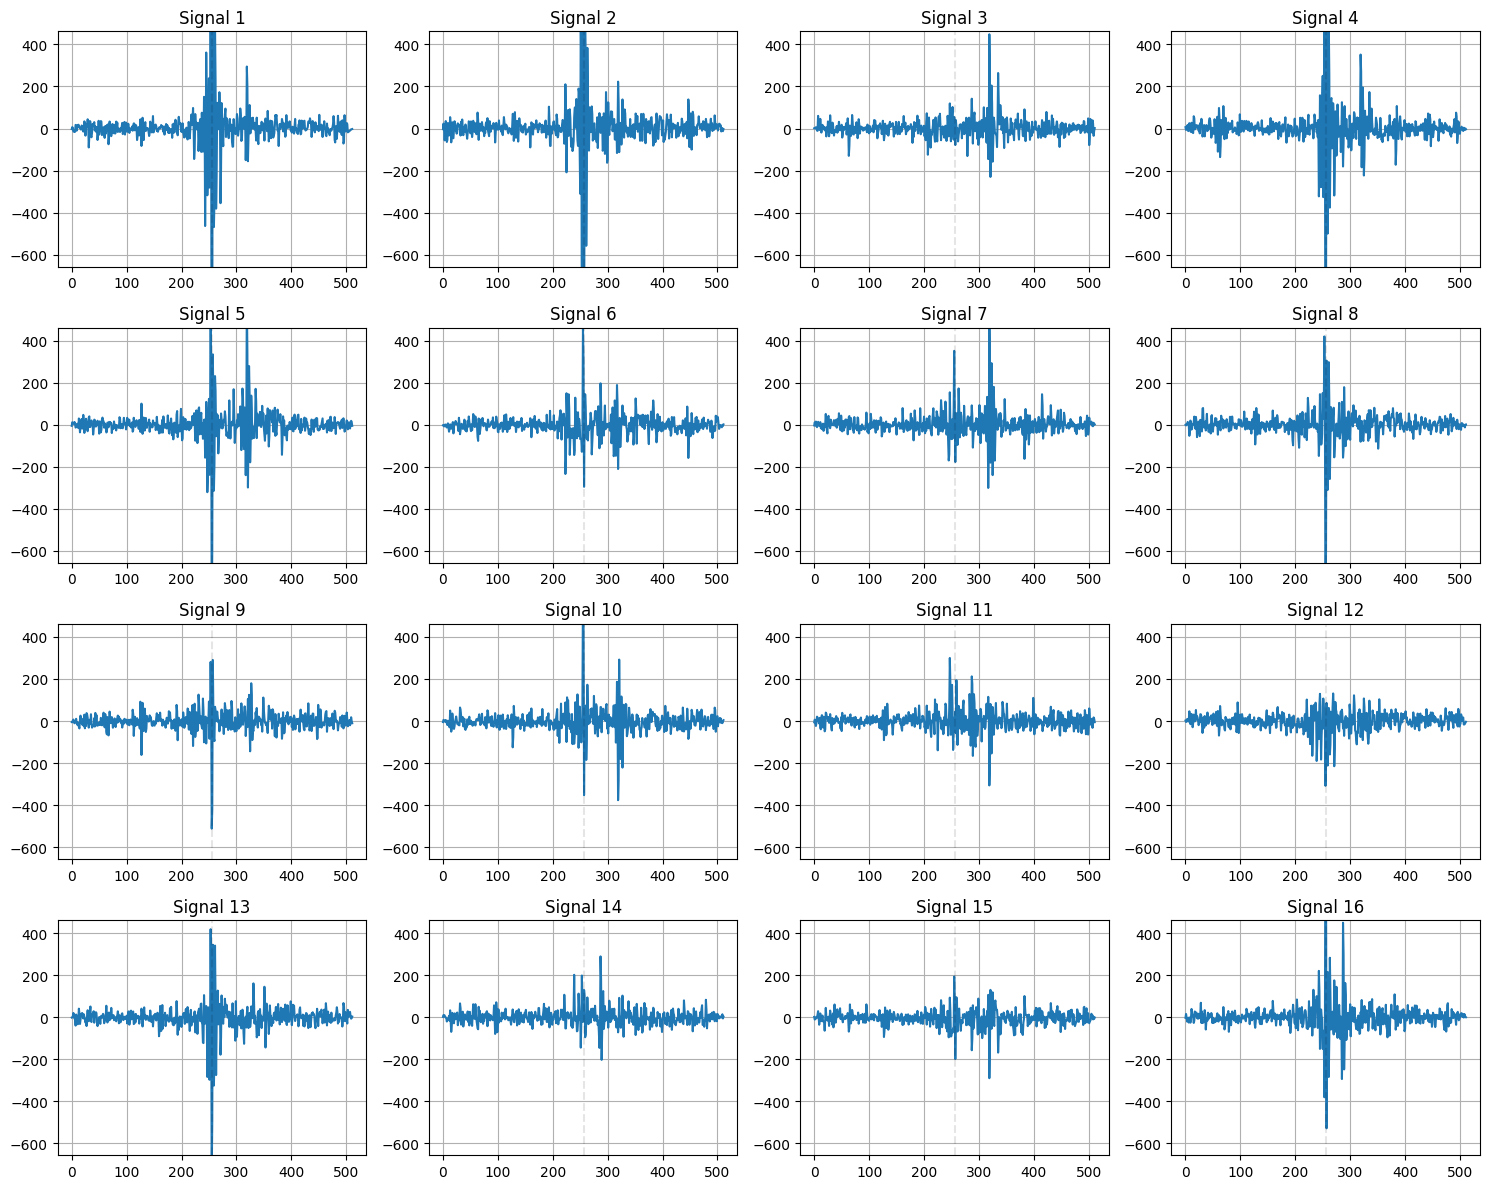

[3/20][0/188]	Loss_D: 1.0764	Loss_G: 2.1853	D(x): 0.1550	D(G(z)): 0.6729 / 0.7912
[3/20][50/188]	Loss_D: 0.7098	Loss_G: 3.1235	D(x): 0.1942	D(G(z)): 0.7746 / 0.7814
[3/20][100/188]	Loss_D: 0.9484	Loss_G: 3.1189	D(x): 0.1088	D(G(z)): 0.7660 / 0.7909
[3/20][150/188]	Loss_D: 0.8535	Loss_G: 1.4327	D(x): 0.1463	D(G(z)): 0.7301 / 0.6444


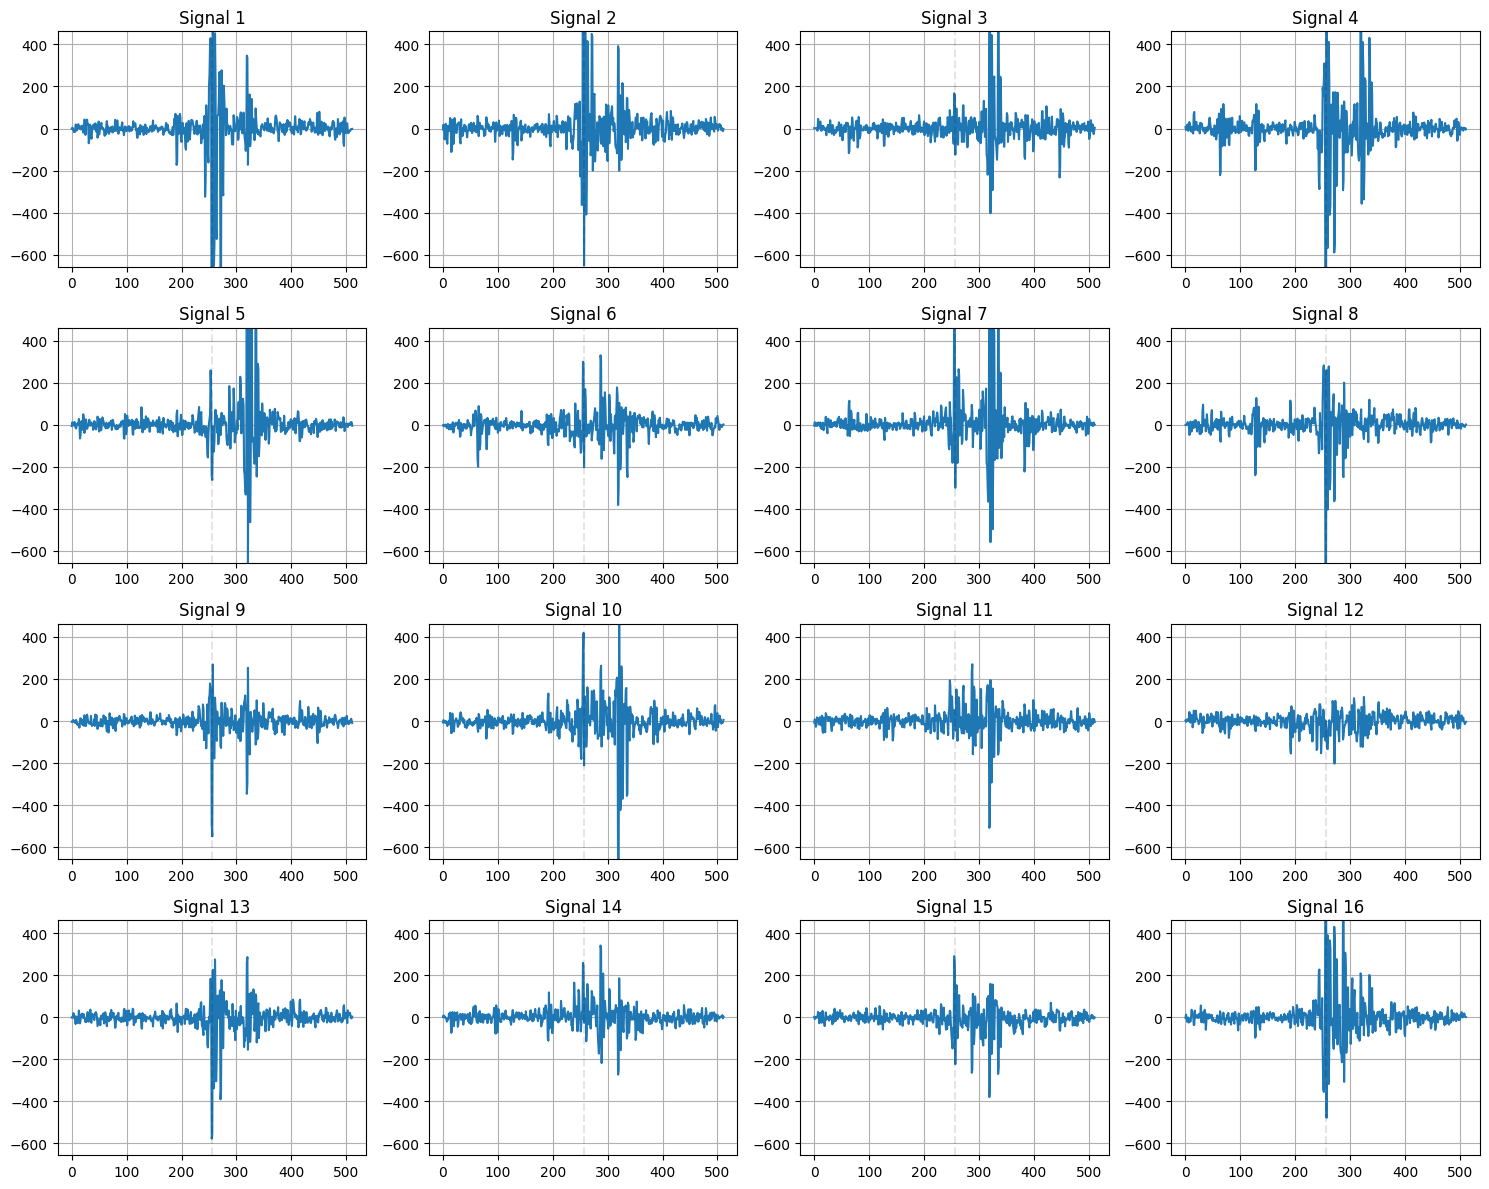

[4/20][0/188]	Loss_D: 0.7689	Loss_G: 3.9845	D(x): 0.2022	D(G(z)): 0.8036 / 0.8719
[4/20][50/188]	Loss_D: 0.4650	Loss_G: 2.6604	D(x): 0.0985	D(G(z)): 0.6839 / 0.7531
[4/20][100/188]	Loss_D: 0.8460	Loss_G: 2.1642	D(x): 0.1519	D(G(z)): 0.8057 / 0.6893
[4/20][150/188]	Loss_D: 0.7745	Loss_G: 2.2615	D(x): 0.1059	D(G(z)): 0.7999 / 0.7130


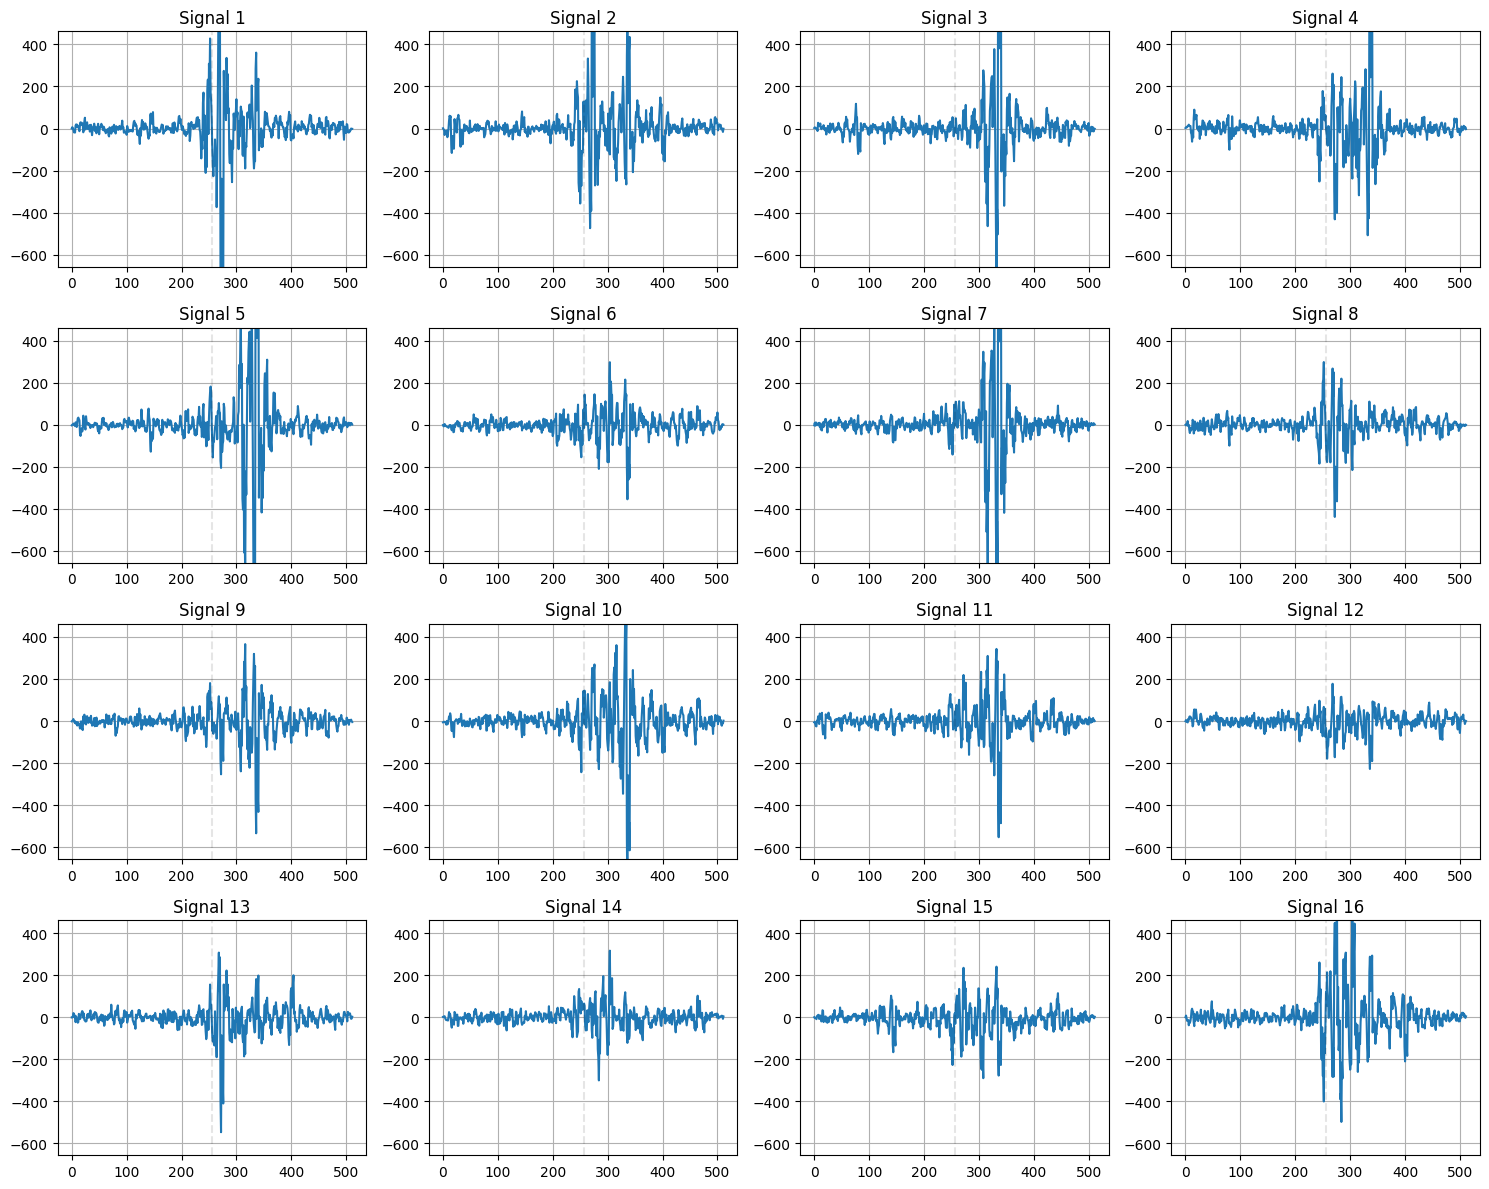

[5/20][0/188]	Loss_D: 0.9017	Loss_G: 2.4896	D(x): 0.2012	D(G(z)): 0.7454 / 0.7595
[5/20][50/188]	Loss_D: 1.0048	Loss_G: 4.1350	D(x): 0.1742	D(G(z)): 0.7031 / 0.8768
[5/20][100/188]	Loss_D: 0.6603	Loss_G: 2.1558	D(x): 0.1017	D(G(z)): 0.7276 / 0.7102
[5/20][150/188]	Loss_D: 0.7235	Loss_G: 2.8789	D(x): 0.2286	D(G(z)): 0.8477 / 0.7386


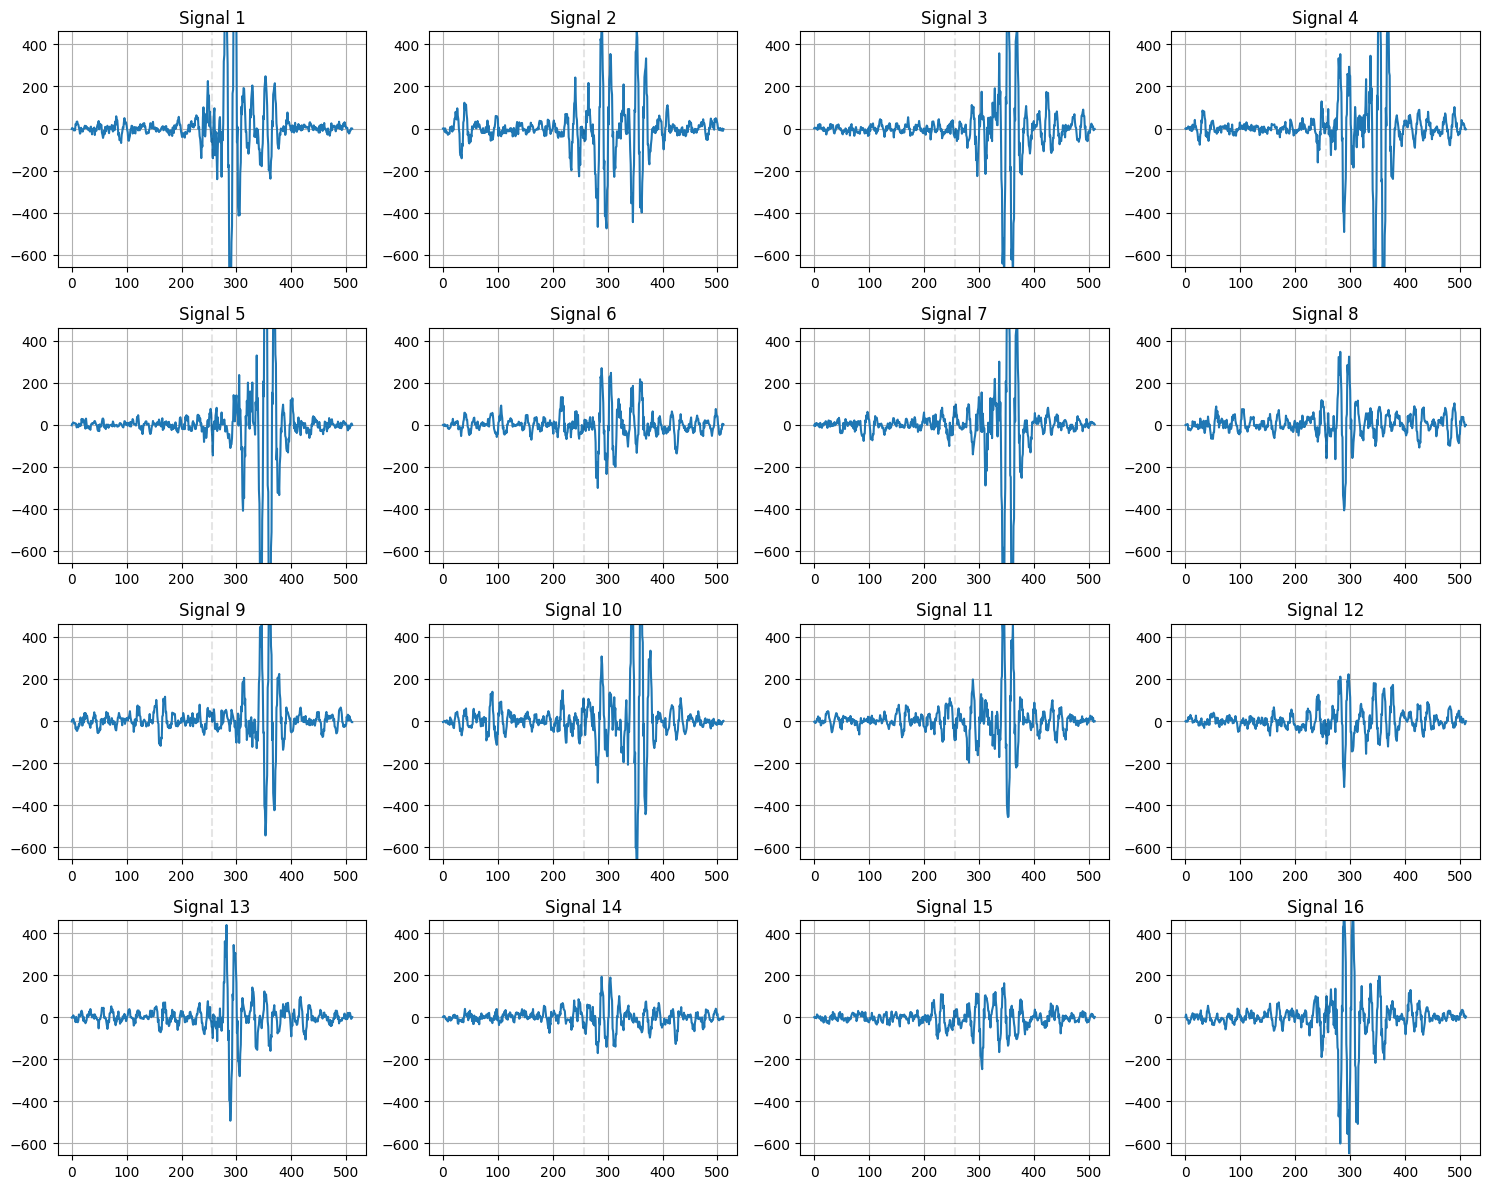

[6/20][0/188]	Loss_D: 0.5568	Loss_G: 1.8036	D(x): 0.1767	D(G(z)): 0.7074 / 0.7005
[6/20][50/188]	Loss_D: 0.7761	Loss_G: 2.8840	D(x): 0.0884	D(G(z)): 0.8102 / 0.7940
[6/20][100/188]	Loss_D: 0.6644	Loss_G: 1.8477	D(x): 0.1626	D(G(z)): 0.7048 / 0.7181
[6/20][150/188]	Loss_D: 1.1314	Loss_G: 2.0261	D(x): 0.1908	D(G(z)): 0.7122 / 0.7166


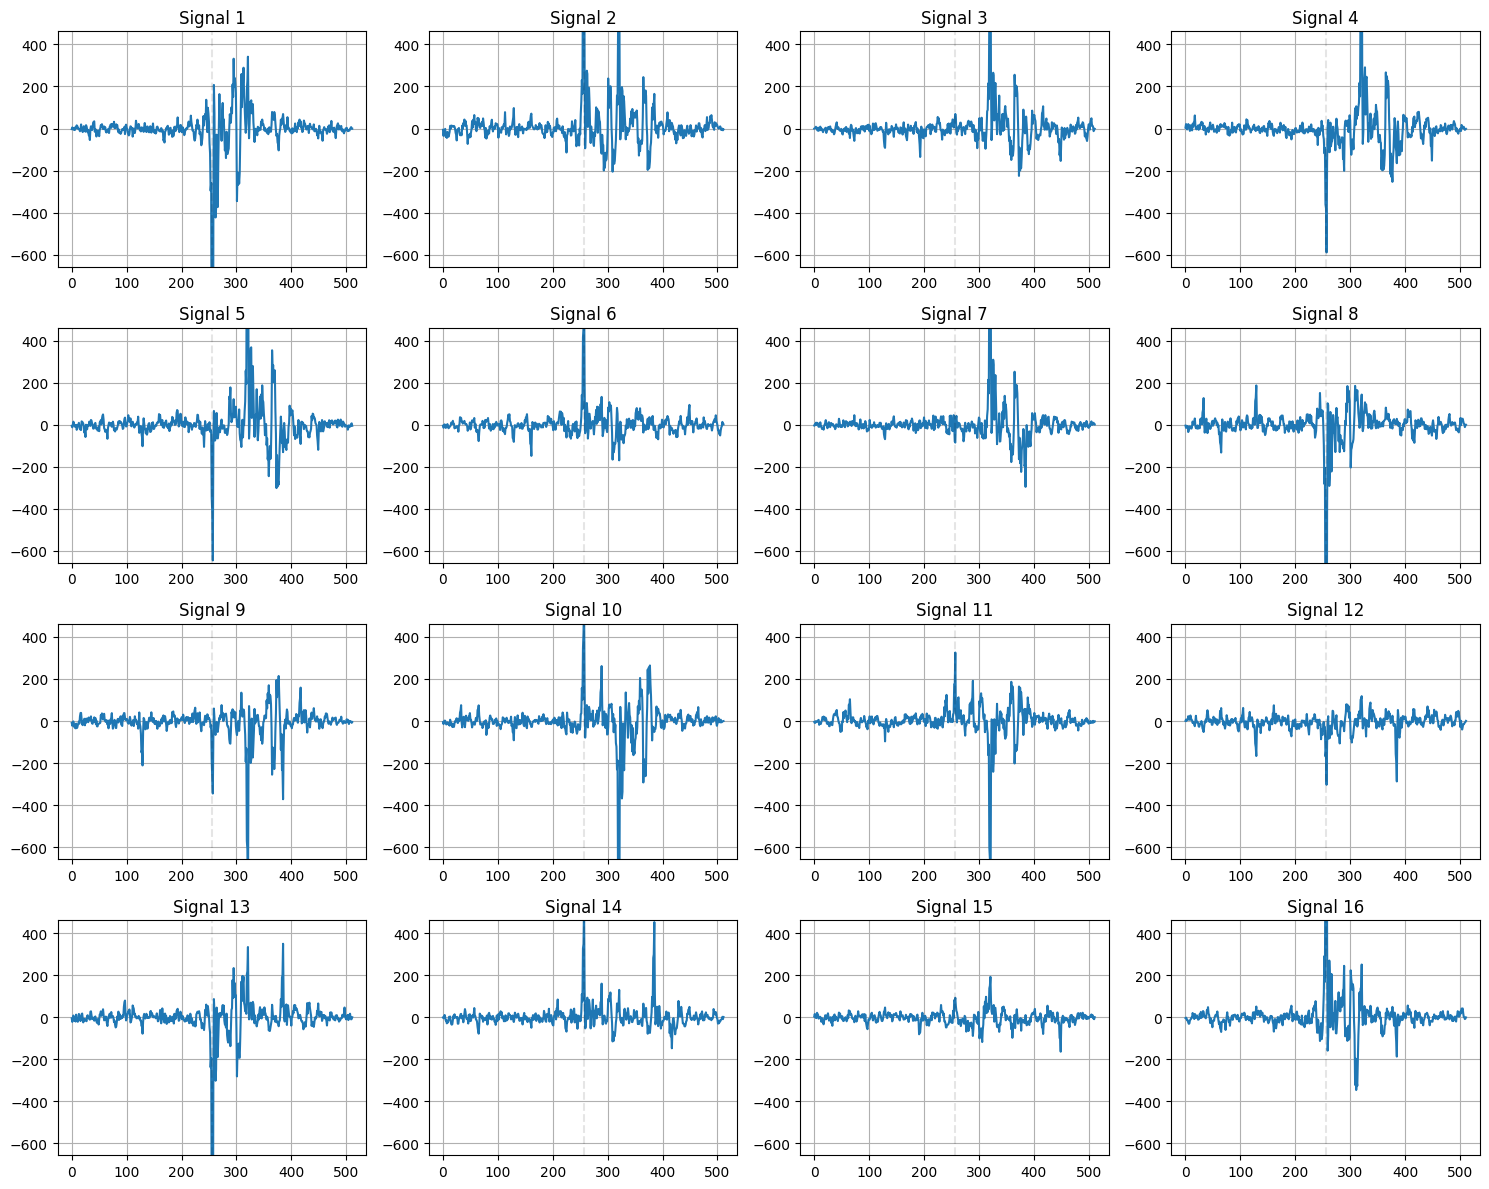

[7/20][0/188]	Loss_D: 0.8149	Loss_G: 1.8721	D(x): 0.1247	D(G(z)): 0.7025 / 0.6452
[7/20][50/188]	Loss_D: 0.9026	Loss_G: 3.3489	D(x): 0.1966	D(G(z)): 0.8324 / 0.8086
[7/20][100/188]	Loss_D: 0.3985	Loss_G: 2.6048	D(x): 0.1224	D(G(z)): 0.7729 / 0.8018
[7/20][150/188]	Loss_D: 1.1210	Loss_G: 1.1952	D(x): 0.1356	D(G(z)): 0.5312 / 0.6116


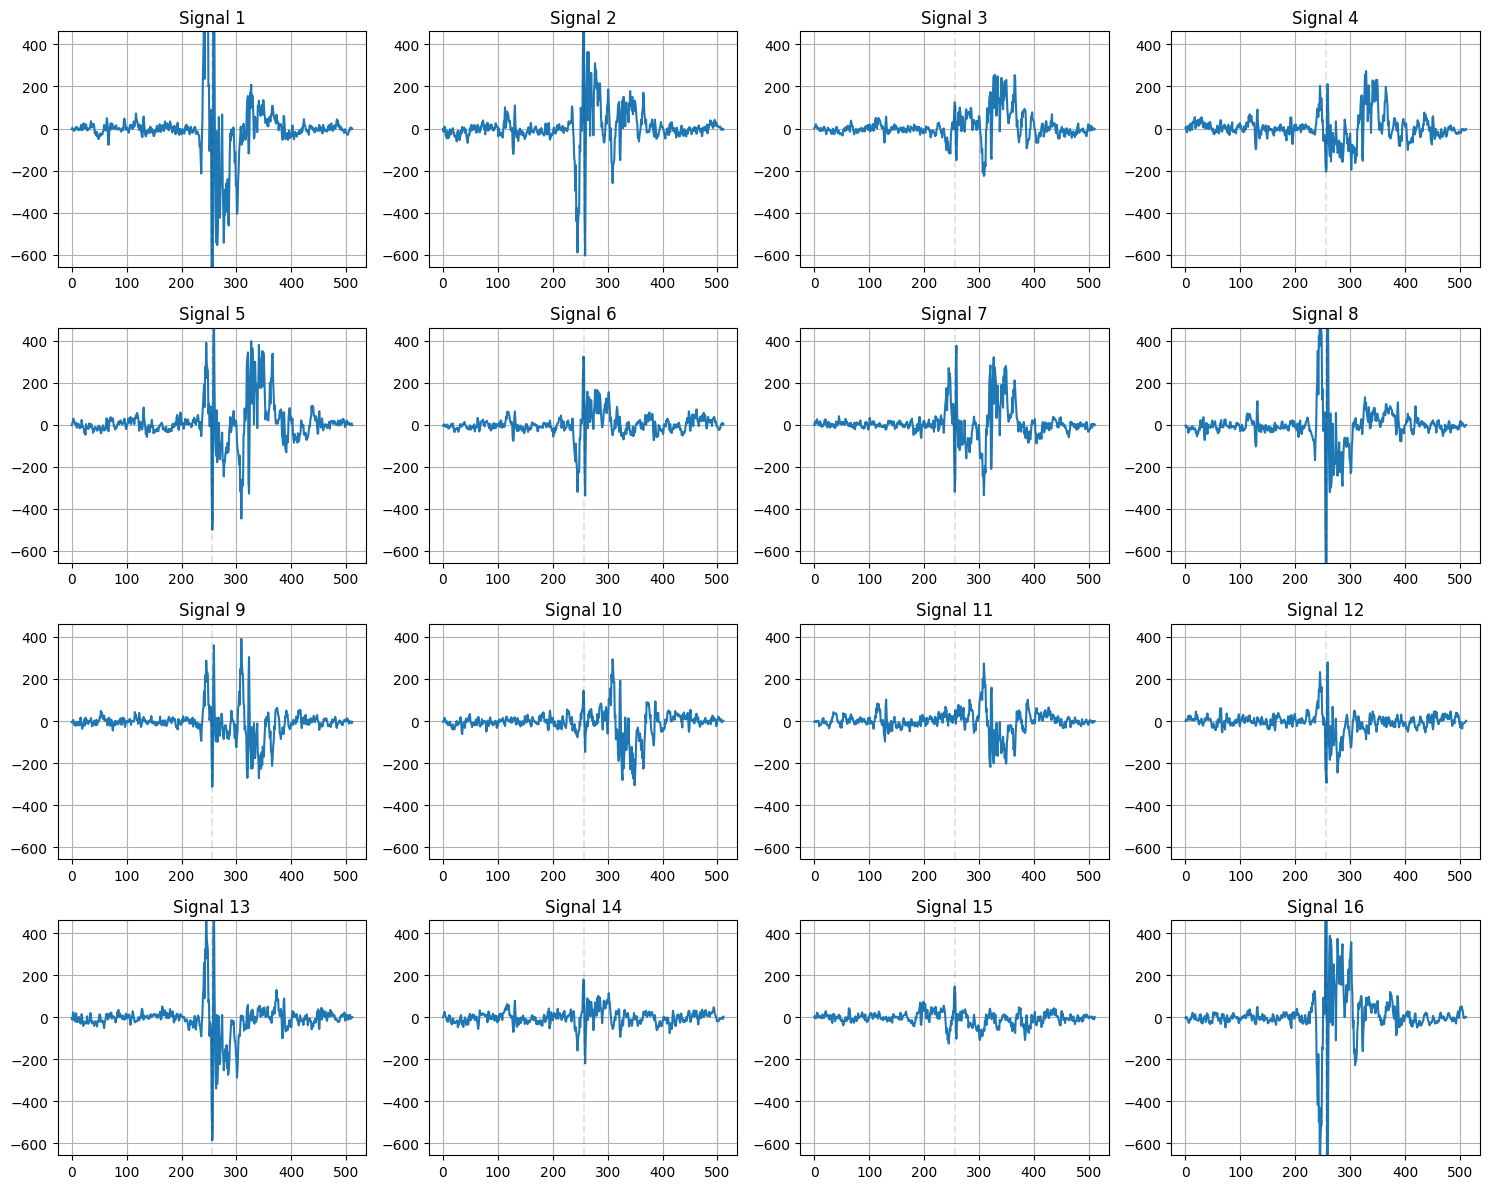

[8/20][0/188]	Loss_D: 0.9474	Loss_G: 1.9060	D(x): 0.2076	D(G(z)): 0.7573 / 0.7276
[8/20][50/188]	Loss_D: 0.8084	Loss_G: 2.4793	D(x): 0.1380	D(G(z)): 0.7481 / 0.7453
[8/20][100/188]	Loss_D: 1.0420	Loss_G: 2.0618	D(x): 0.2321	D(G(z)): 0.7094 / 0.7316
[8/20][150/188]	Loss_D: 0.9041	Loss_G: 2.9506	D(x): 0.1488	D(G(z)): 0.7608 / 0.8185


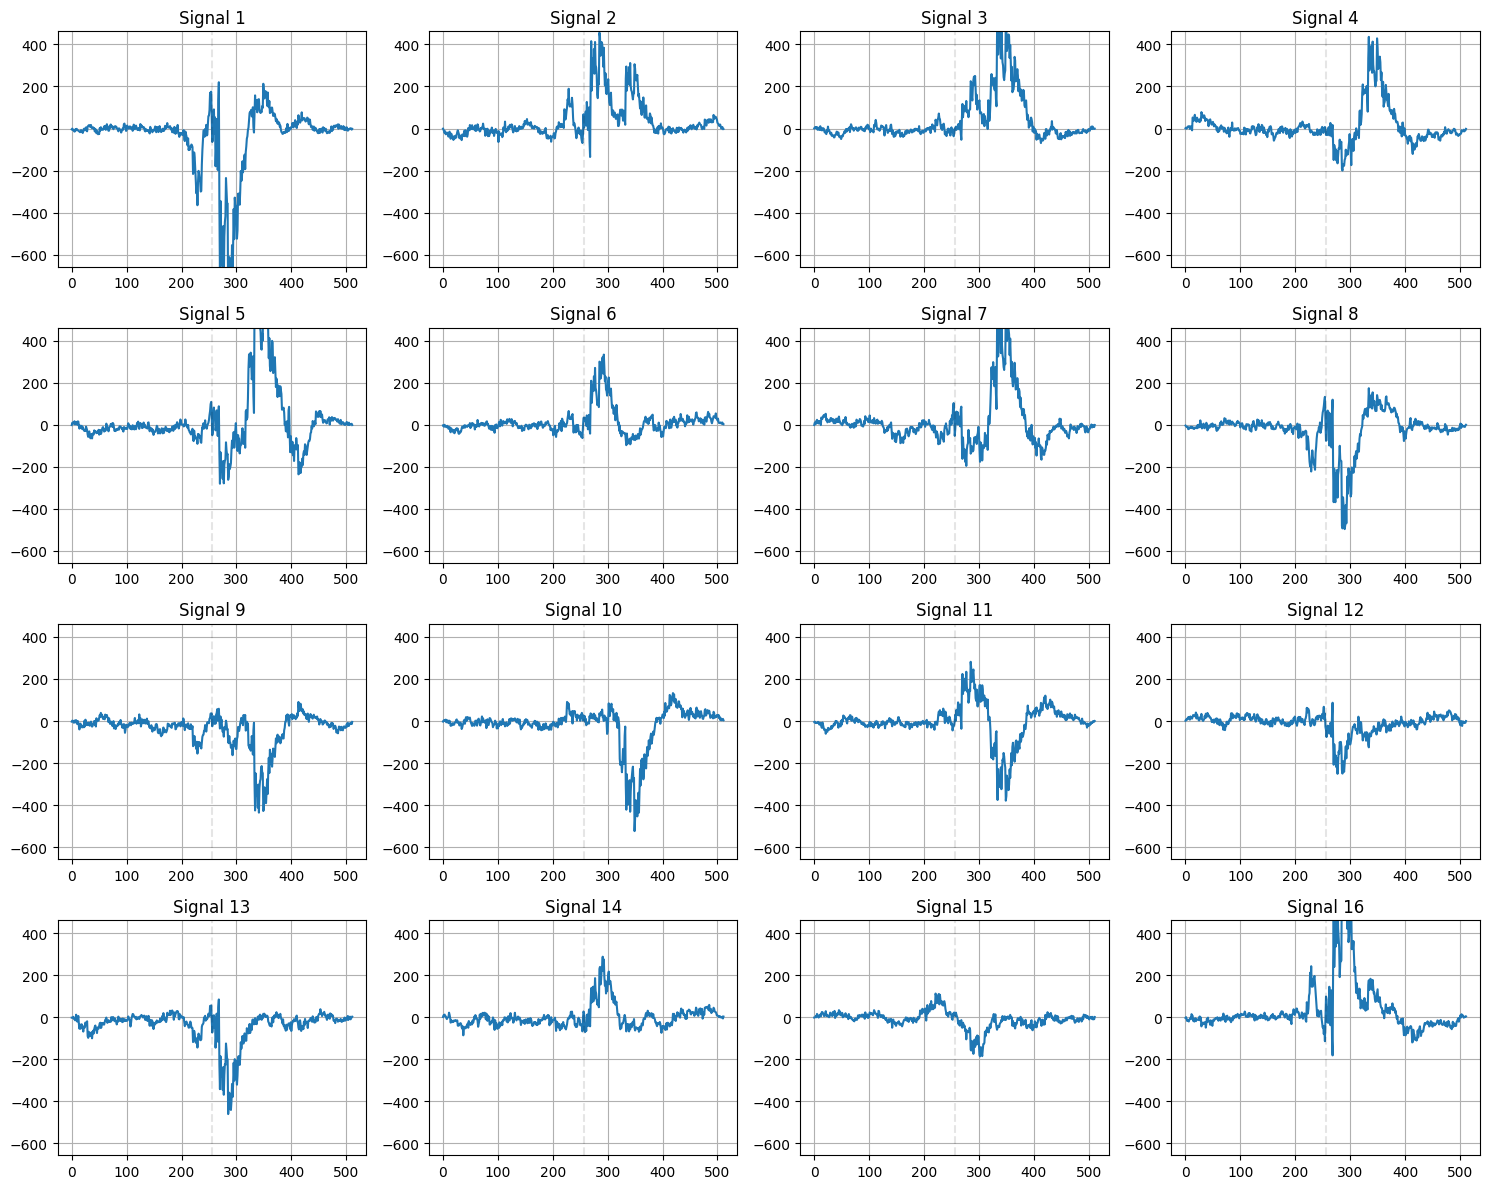

[9/20][0/188]	Loss_D: 0.7694	Loss_G: 3.9162	D(x): 0.0933	D(G(z)): 0.6546 / 0.8294
[9/20][50/188]	Loss_D: 1.0333	Loss_G: 2.4326	D(x): 0.1728	D(G(z)): 0.6895 / 0.7602
[9/20][100/188]	Loss_D: 0.6427	Loss_G: 2.8767	D(x): 0.0945	D(G(z)): 0.8371 / 0.7645
[9/20][150/188]	Loss_D: 0.8705	Loss_G: 3.3619	D(x): 0.1641	D(G(z)): 0.7920 / 0.7925


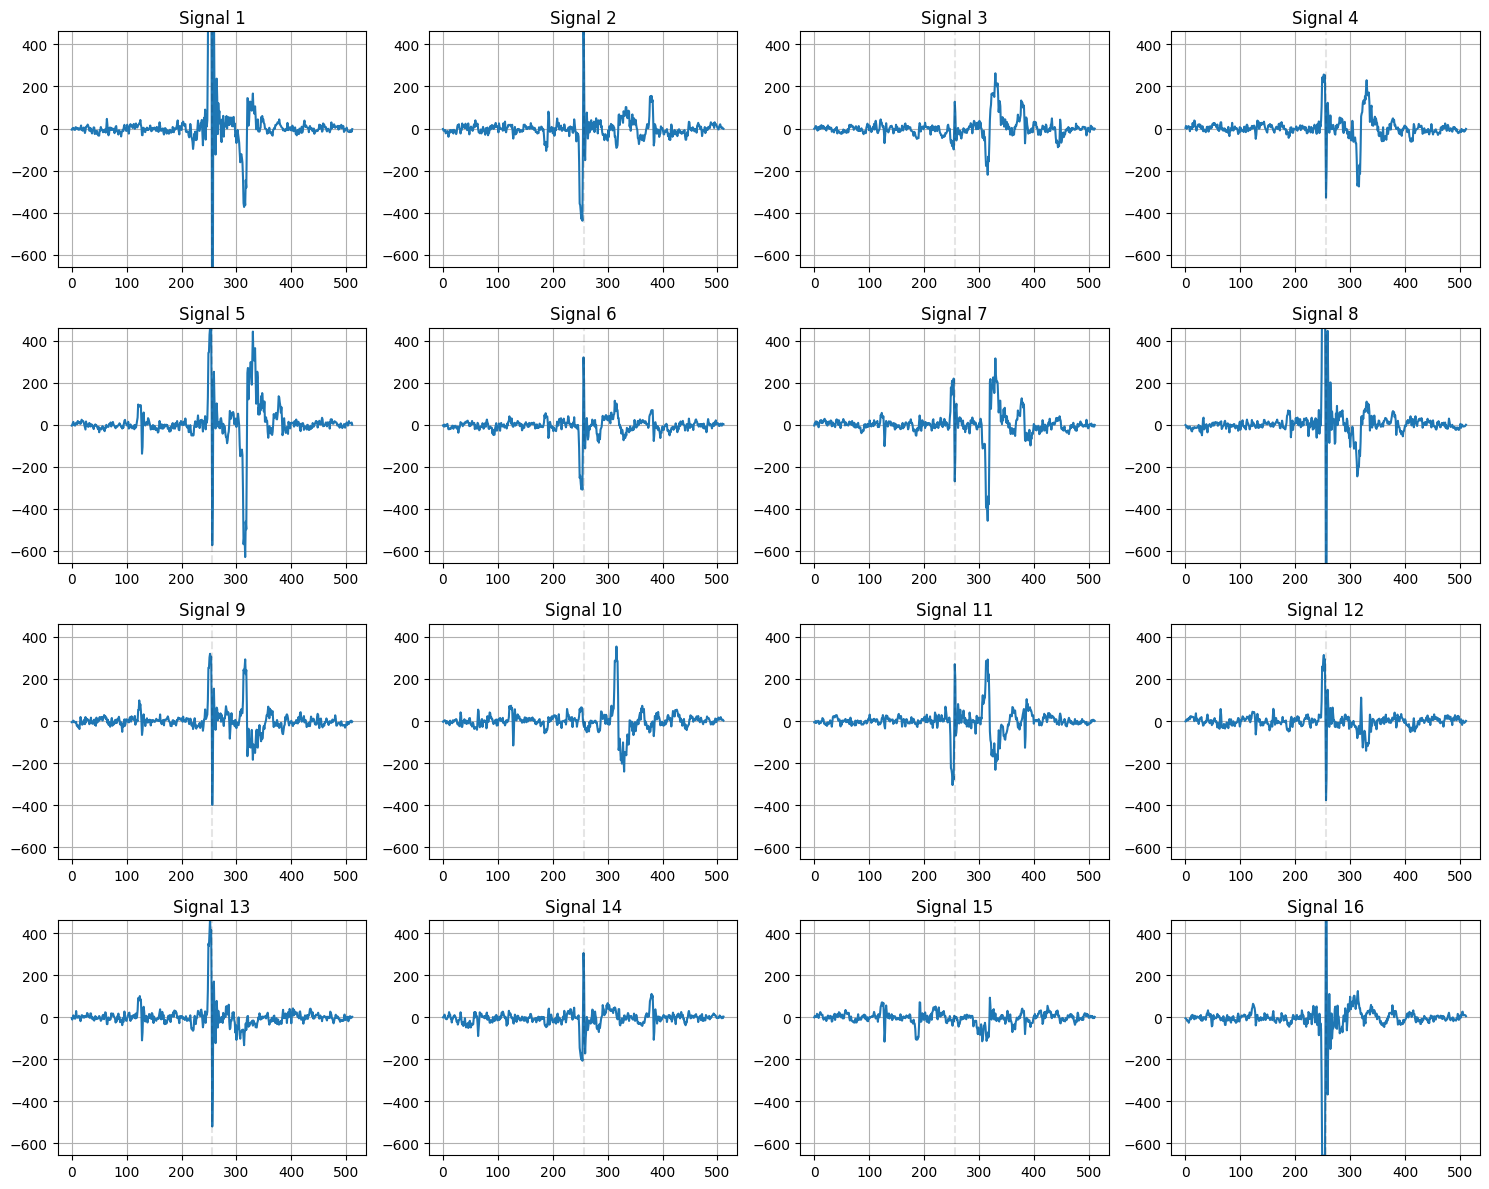

[10/20][0/188]	Loss_D: 1.2109	Loss_G: 2.9217	D(x): 0.1967	D(G(z)): 0.8230 / 0.8103
[10/20][50/188]	Loss_D: 0.8570	Loss_G: 2.7510	D(x): 0.1978	D(G(z)): 0.8627 / 0.7939
[10/20][100/188]	Loss_D: 0.8432	Loss_G: 2.0982	D(x): 0.0876	D(G(z)): 0.7015 / 0.7139
[10/20][150/188]	Loss_D: 0.4889	Loss_G: 2.7056	D(x): 0.1302	D(G(z)): 0.8452 / 0.7346


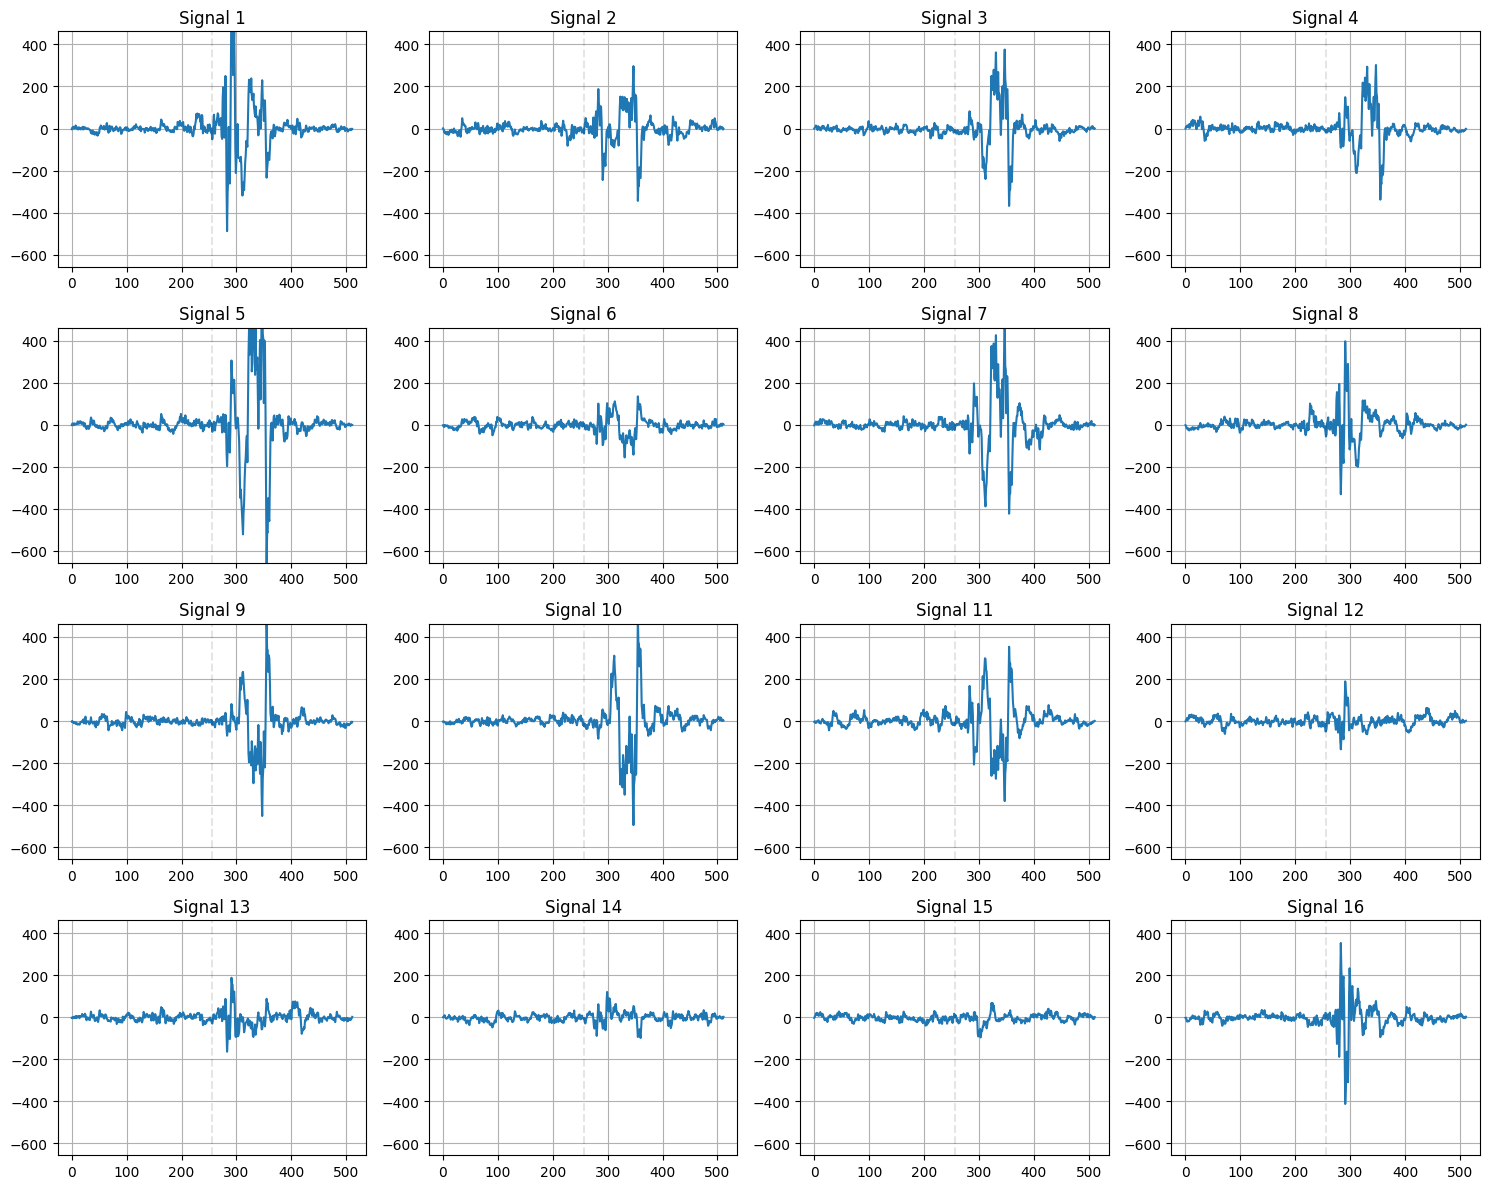

[11/20][0/188]	Loss_D: 0.7694	Loss_G: 2.3719	D(x): 0.1915	D(G(z)): 0.6949 / 0.7694
[11/20][50/188]	Loss_D: 0.6875	Loss_G: 2.9351	D(x): 0.1218	D(G(z)): 0.8225 / 0.7877
[11/20][100/188]	Loss_D: 0.8631	Loss_G: 2.5606	D(x): 0.1747	D(G(z)): 0.7724 / 0.7649
[11/20][150/188]	Loss_D: 0.9431	Loss_G: 3.7615	D(x): 0.1939	D(G(z)): 0.7500 / 0.8579


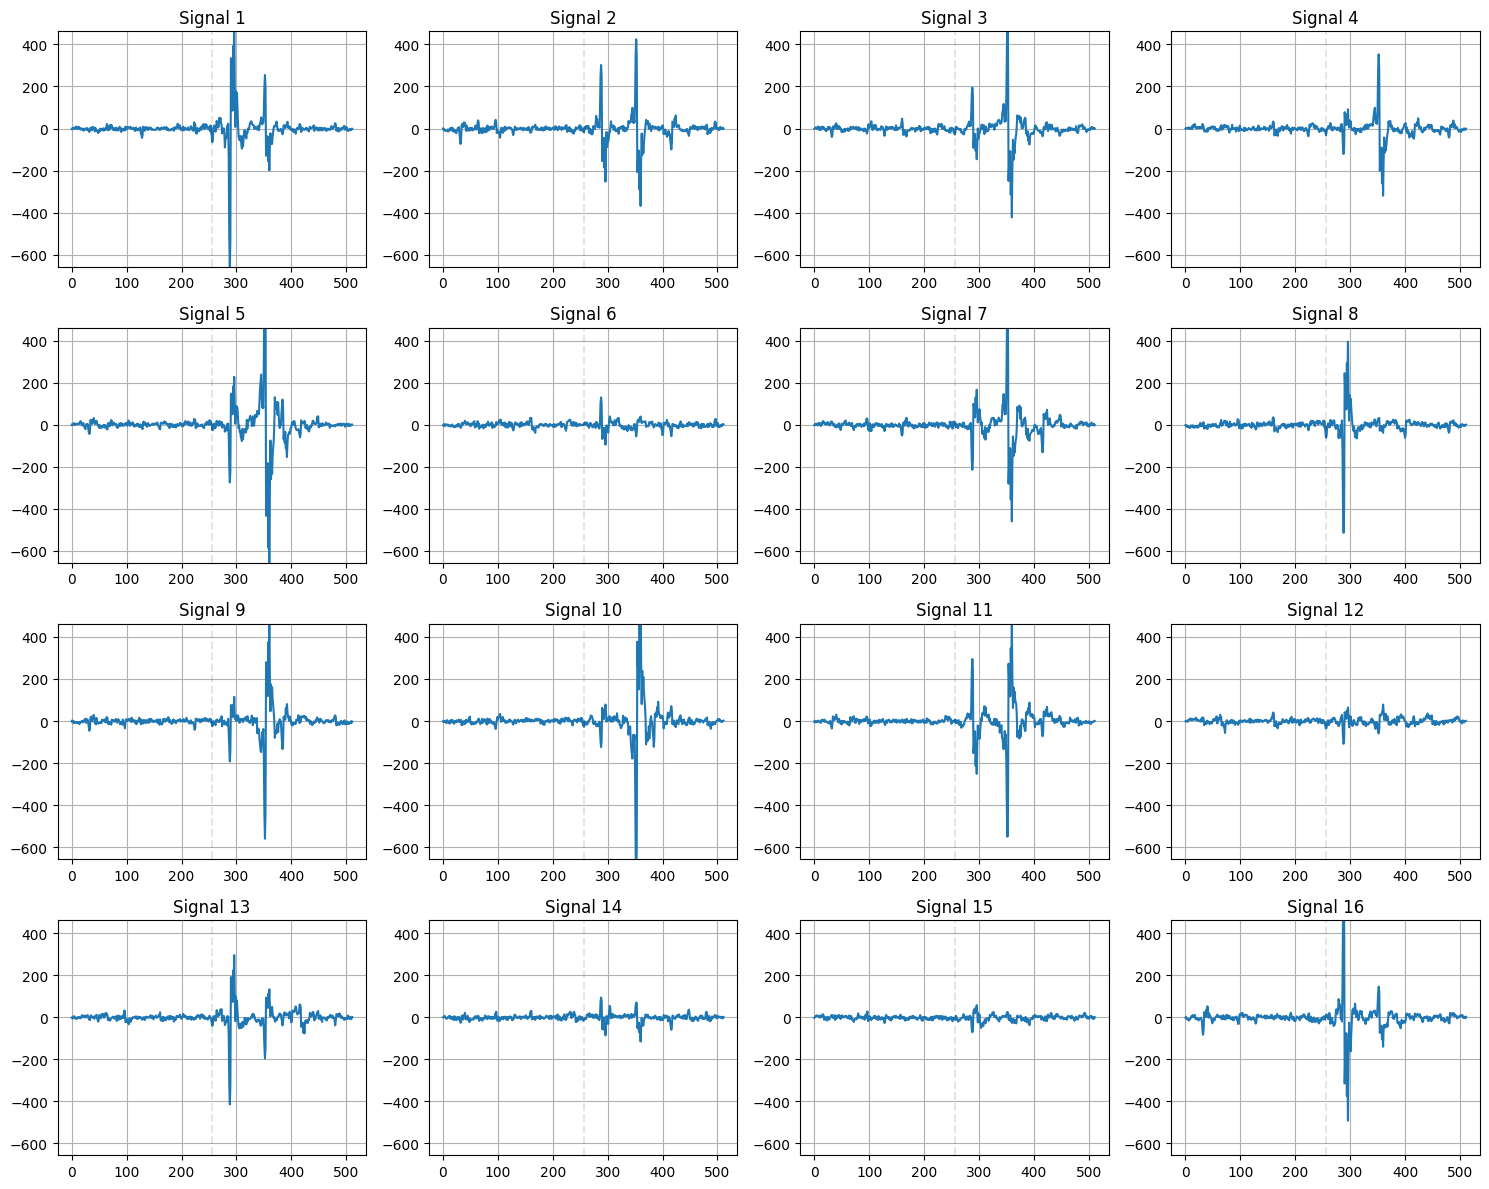

[12/20][0/188]	Loss_D: 0.5507	Loss_G: 2.5343	D(x): 0.1786	D(G(z)): 0.6901 / 0.8178
[12/20][50/188]	Loss_D: 0.5941	Loss_G: 3.3746	D(x): 0.1043	D(G(z)): 0.8252 / 0.8083
[12/20][100/188]	Loss_D: 1.3411	Loss_G: 4.6936	D(x): 0.1314	D(G(z)): 0.5904 / 0.7648
[12/20][150/188]	Loss_D: 1.0264	Loss_G: 3.2846	D(x): 0.2091	D(G(z)): 0.7223 / 0.8512


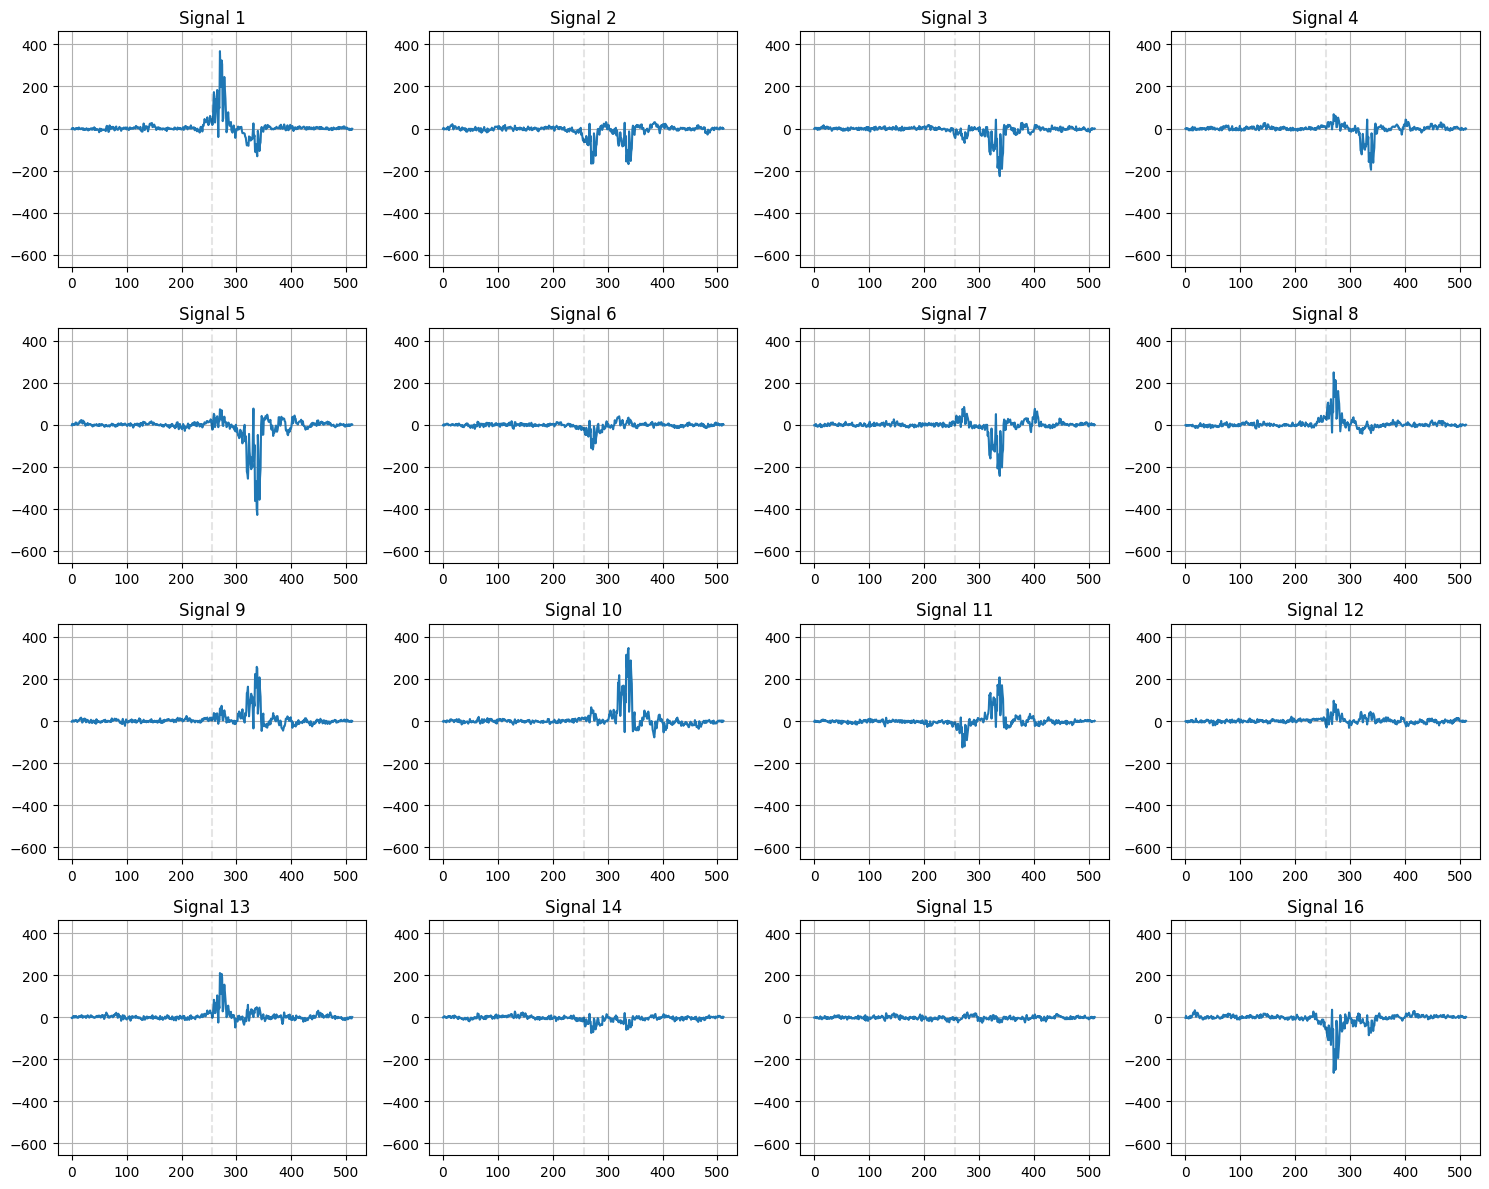

[13/20][0/188]	Loss_D: 0.5150	Loss_G: 1.2498	D(x): 0.1360	D(G(z)): 0.7997 / 0.6277
[13/20][50/188]	Loss_D: 0.8537	Loss_G: 2.1880	D(x): 0.1574	D(G(z)): 0.6786 / 0.7308
[13/20][100/188]	Loss_D: 0.8172	Loss_G: 2.6716	D(x): 0.1721	D(G(z)): 0.7539 / 0.7689
[13/20][150/188]	Loss_D: 0.7475	Loss_G: 1.6985	D(x): 0.0723	D(G(z)): 0.7846 / 0.6867


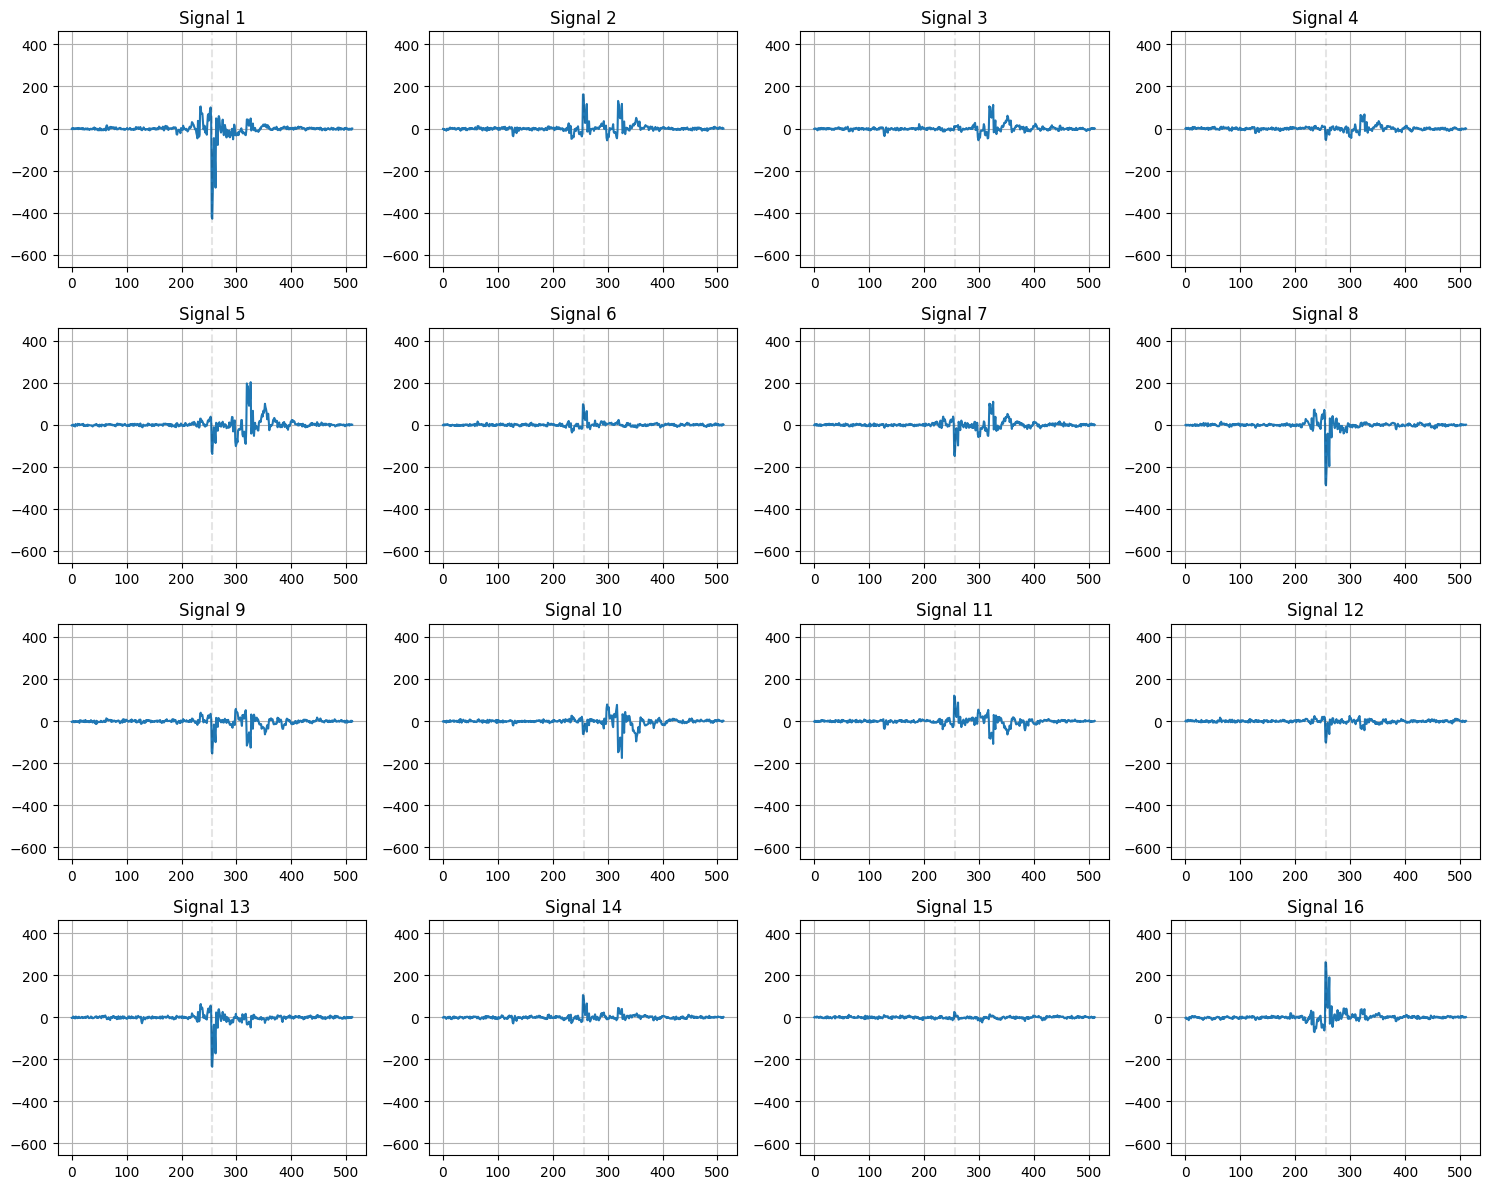

[14/20][0/188]	Loss_D: 0.4430	Loss_G: 2.3065	D(x): 0.1376	D(G(z)): 0.8274 / 0.7897
[14/20][50/188]	Loss_D: 1.3876	Loss_G: 2.7164	D(x): 0.1112	D(G(z)): 0.7279 / 0.7759
[14/20][100/188]	Loss_D: 0.4677	Loss_G: 2.0979	D(x): 0.1527	D(G(z)): 0.8252 / 0.7793
[14/20][150/188]	Loss_D: 0.9556	Loss_G: 2.7182	D(x): 0.1296	D(G(z)): 0.8486 / 0.8367


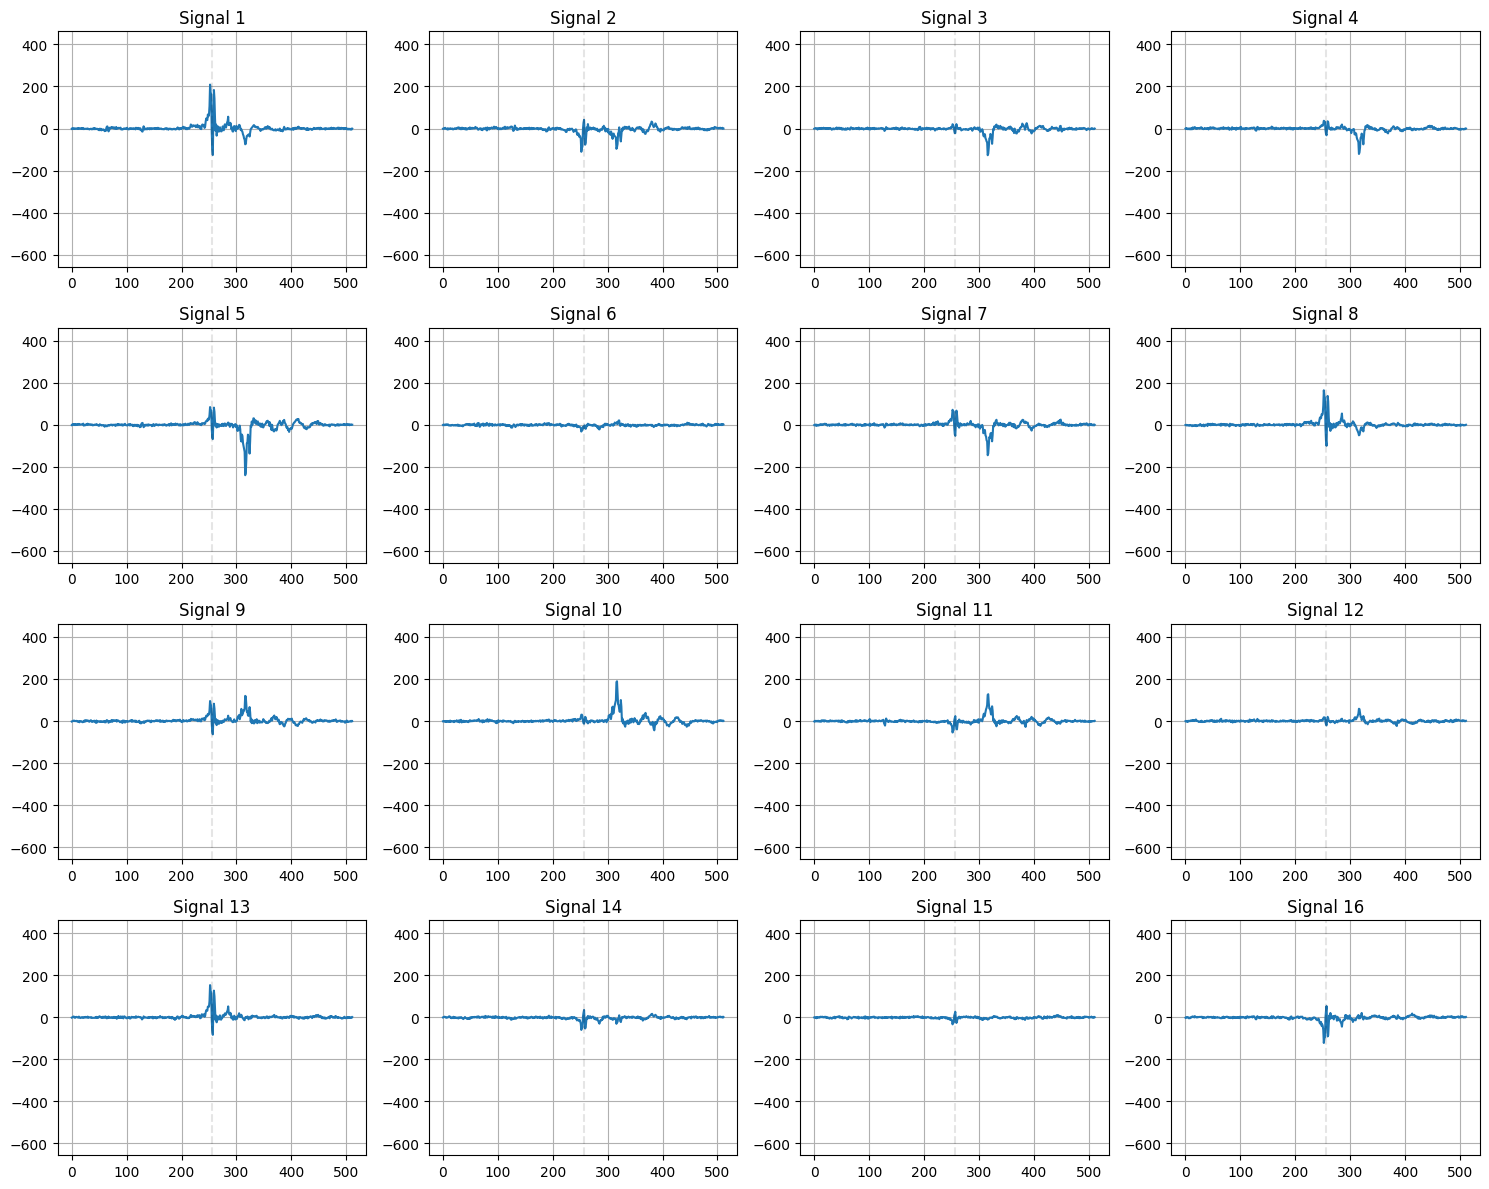

[15/20][0/188]	Loss_D: 0.9420	Loss_G: 1.7165	D(x): 0.1454	D(G(z)): 0.7366 / 0.6910
[15/20][50/188]	Loss_D: 0.7380	Loss_G: 2.0632	D(x): 0.1610	D(G(z)): 0.7968 / 0.7308
[15/20][100/188]	Loss_D: 0.5773	Loss_G: 1.5935	D(x): 0.0385	D(G(z)): 0.7310 / 0.6911
[15/20][150/188]	Loss_D: 0.5635	Loss_G: 2.1966	D(x): 0.1440	D(G(z)): 0.7607 / 0.7985


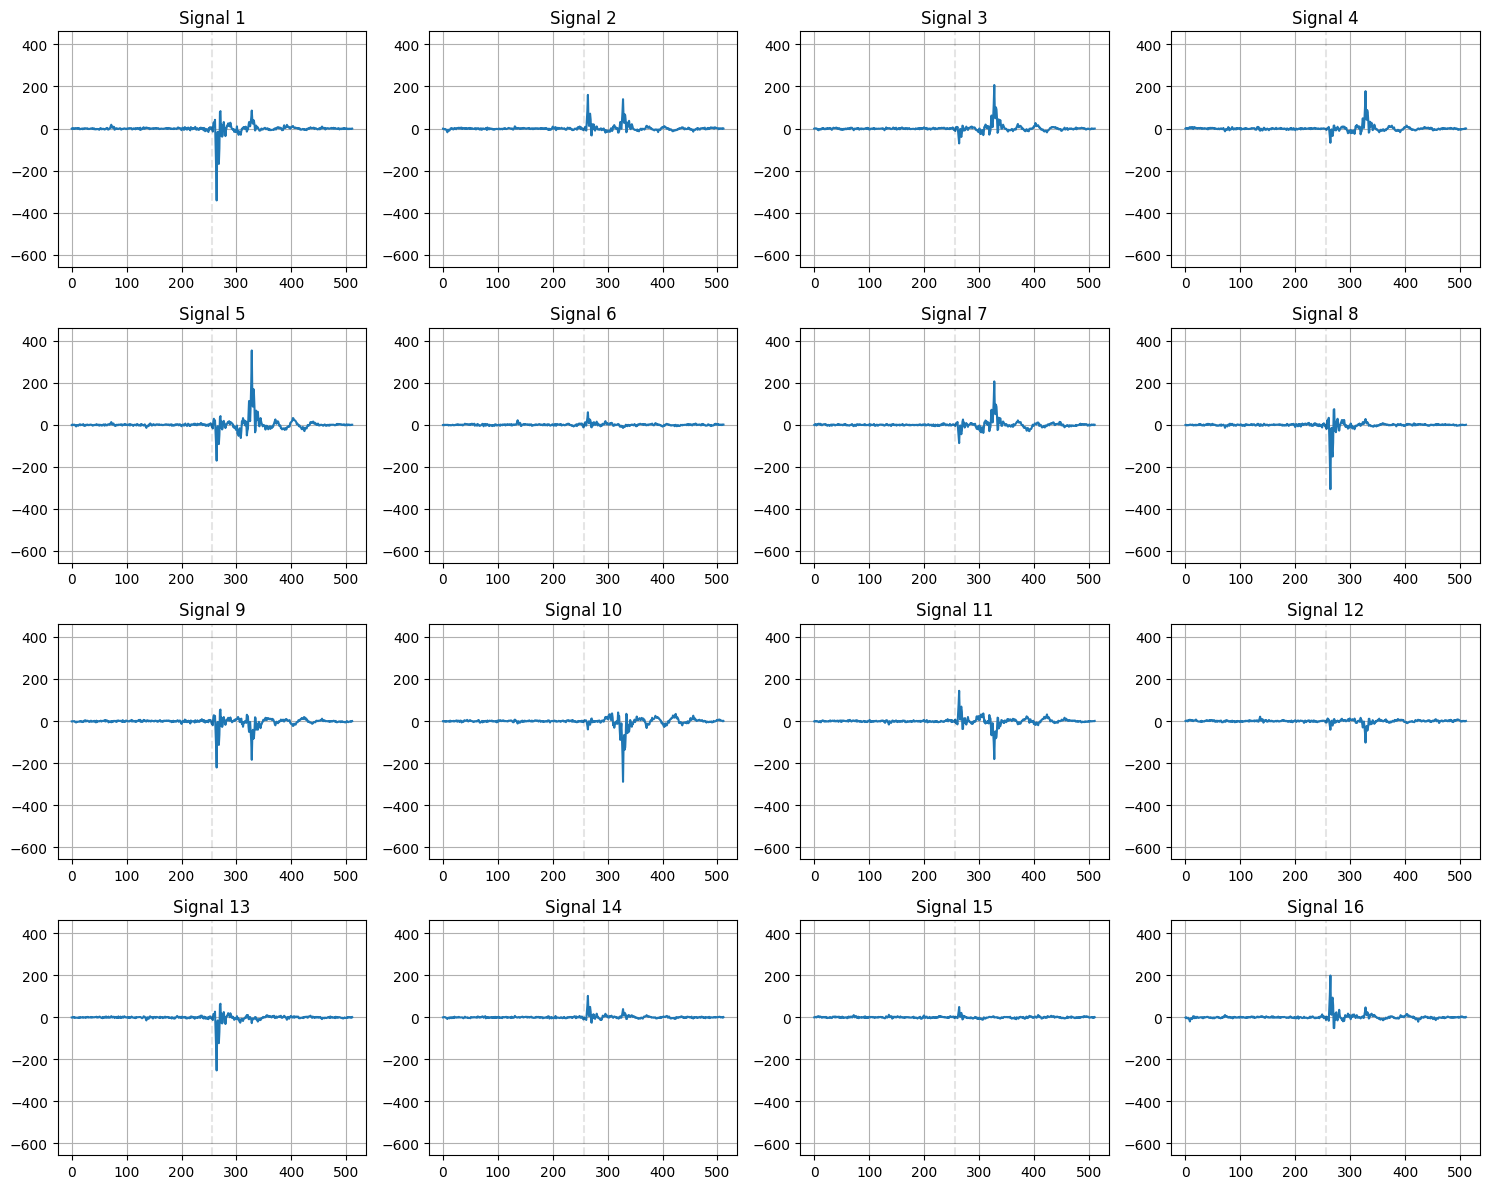

[16/20][0/188]	Loss_D: 0.7060	Loss_G: 2.6085	D(x): 0.1851	D(G(z)): 0.7629 / 0.7775
[16/20][50/188]	Loss_D: 0.8104	Loss_G: 1.8058	D(x): 0.1891	D(G(z)): 0.7965 / 0.7207
[16/20][100/188]	Loss_D: 0.5756	Loss_G: 1.6757	D(x): 0.1581	D(G(z)): 0.7135 / 0.6985
[16/20][150/188]	Loss_D: 0.5114	Loss_G: 3.1169	D(x): 0.1102	D(G(z)): 0.7199 / 0.8062


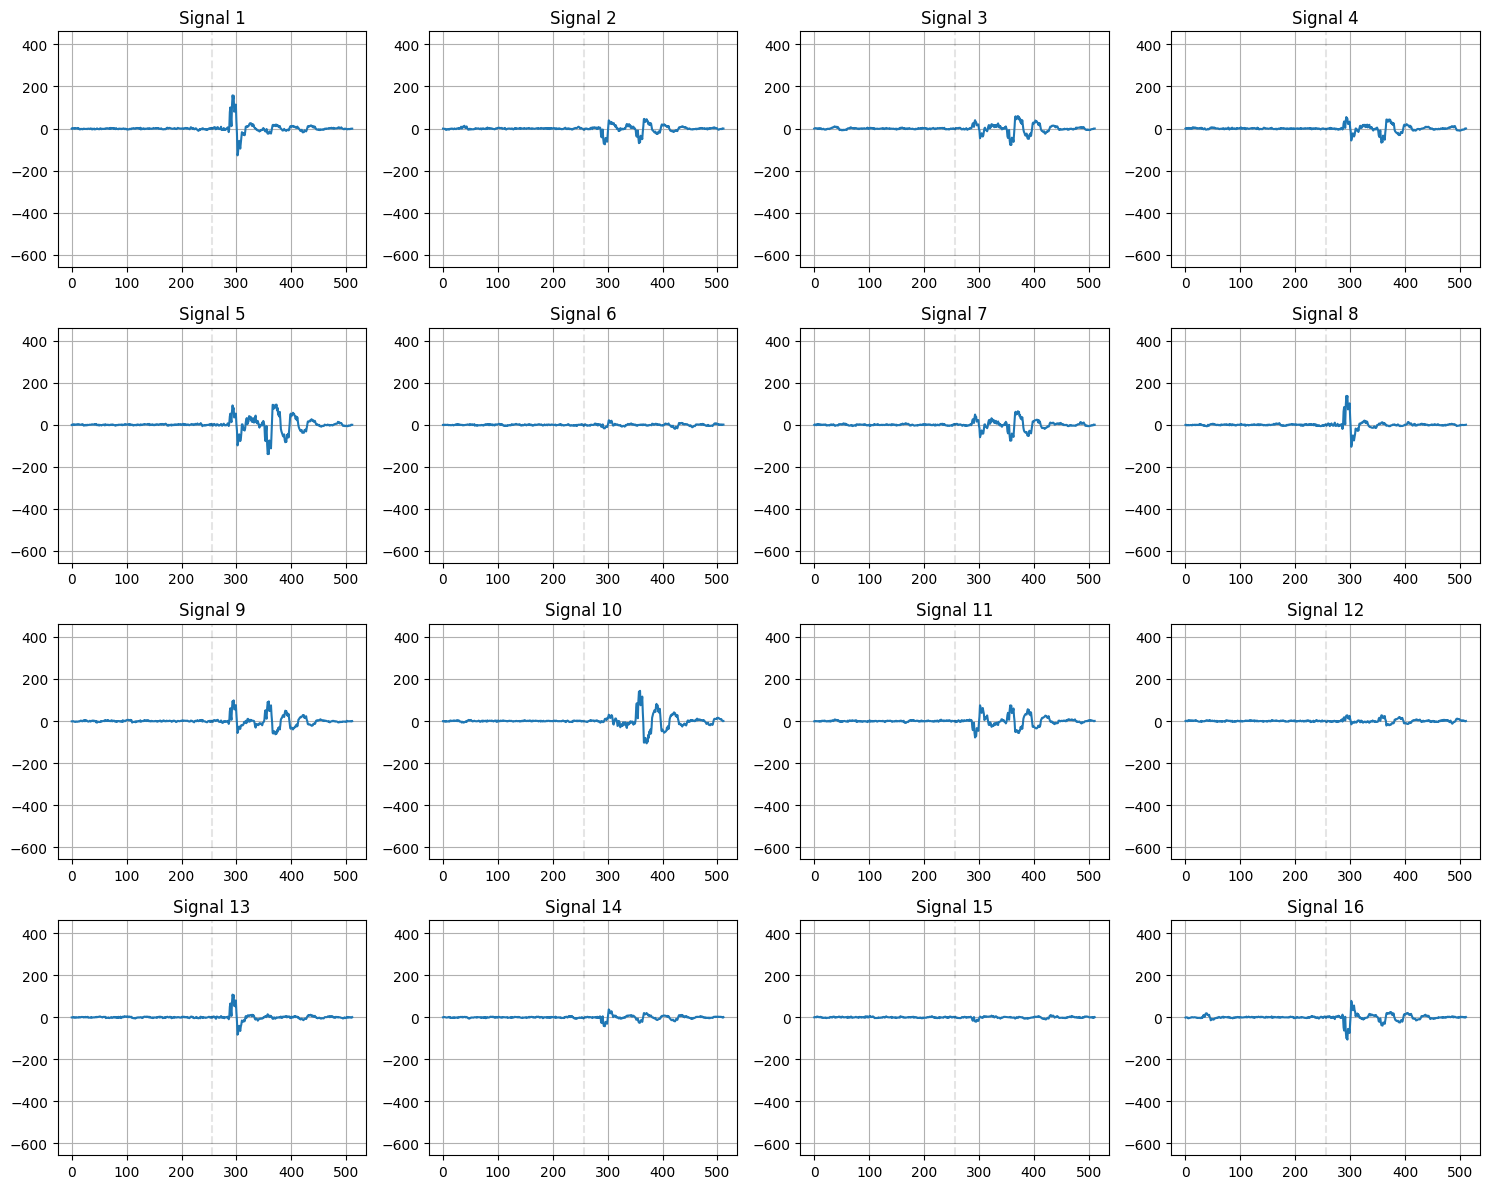

[17/20][0/188]	Loss_D: 1.2441	Loss_G: 1.9218	D(x): 0.1260	D(G(z)): 0.4559 / 0.7101
[17/20][50/188]	Loss_D: 1.0265	Loss_G: 3.2556	D(x): 0.1139	D(G(z)): 0.7996 / 0.8417
[17/20][100/188]	Loss_D: 0.8812	Loss_G: 2.6875	D(x): 0.1934	D(G(z)): 0.6528 / 0.7613
[17/20][150/188]	Loss_D: 0.6121	Loss_G: 1.2155	D(x): 0.0871	D(G(z)): 0.7037 / 0.5926


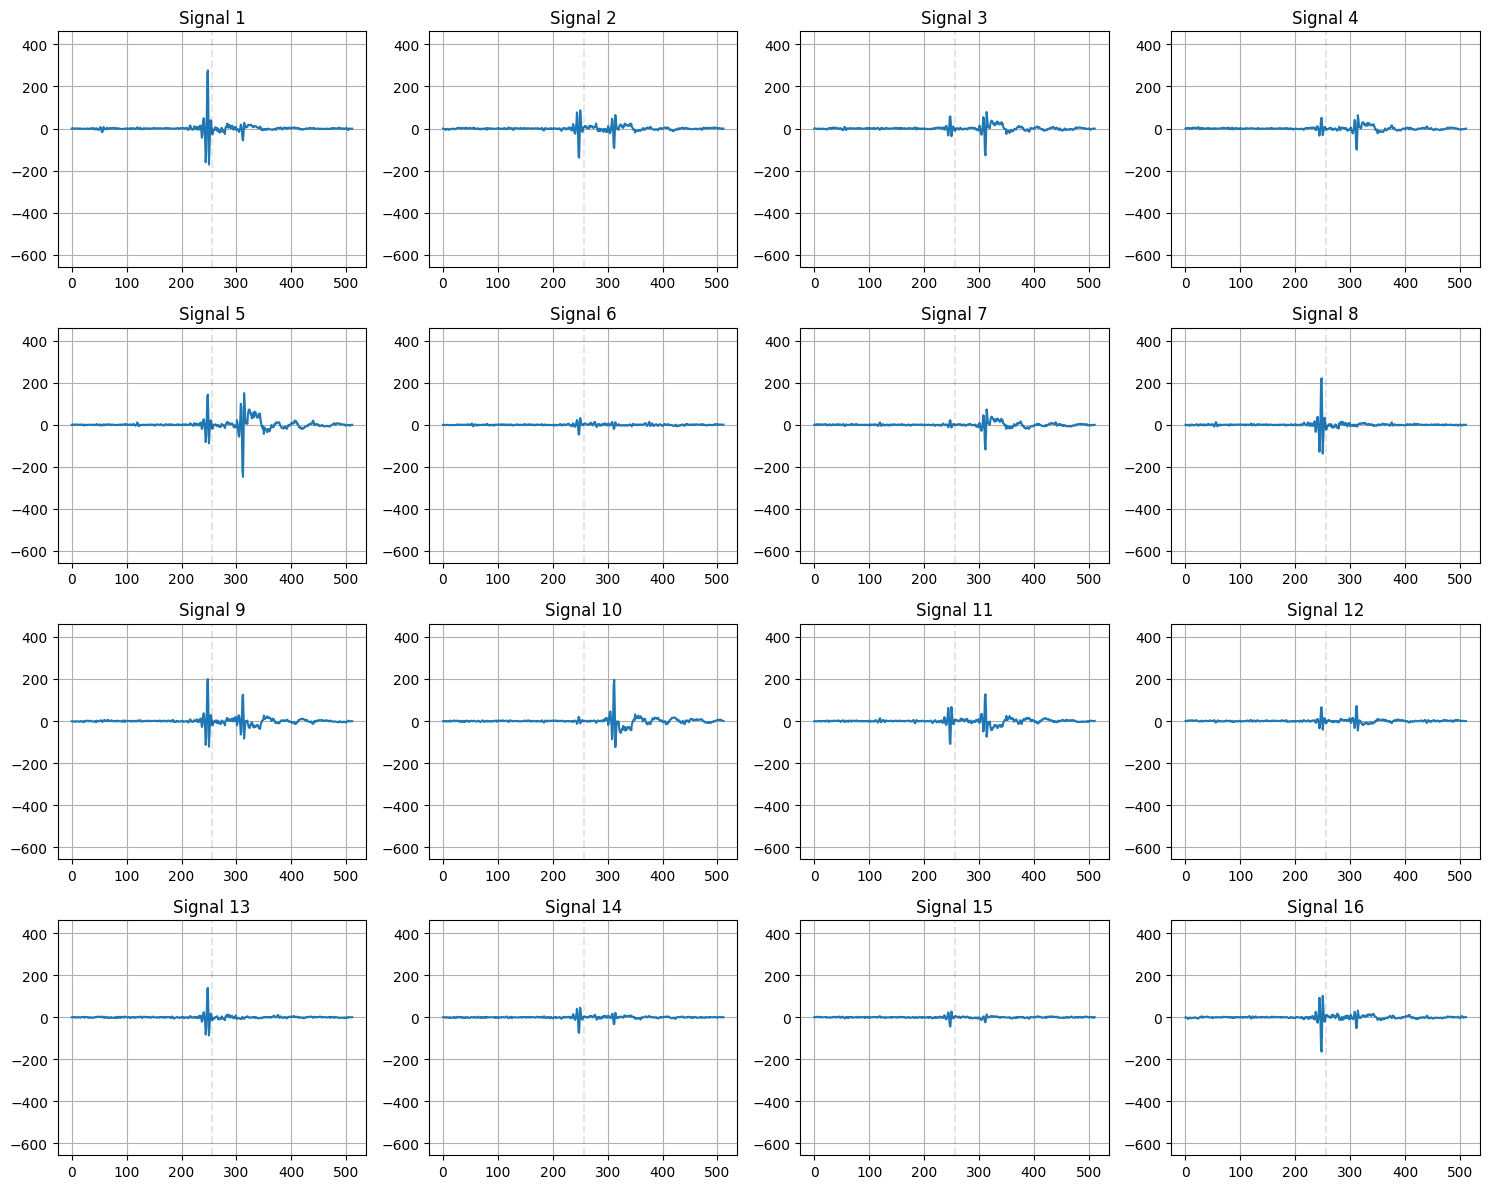

[18/20][0/188]	Loss_D: 0.5709	Loss_G: 3.8079	D(x): 0.1544	D(G(z)): 0.8346 / 0.8209
[18/20][50/188]	Loss_D: 1.0054	Loss_G: 3.3854	D(x): 0.1635	D(G(z)): 0.7902 / 0.8759
[18/20][100/188]	Loss_D: 0.8621	Loss_G: 1.9041	D(x): 0.1389	D(G(z)): 0.7604 / 0.6943
[18/20][150/188]	Loss_D: 1.1138	Loss_G: 3.0390	D(x): 0.1117	D(G(z)): 0.7395 / 0.7681


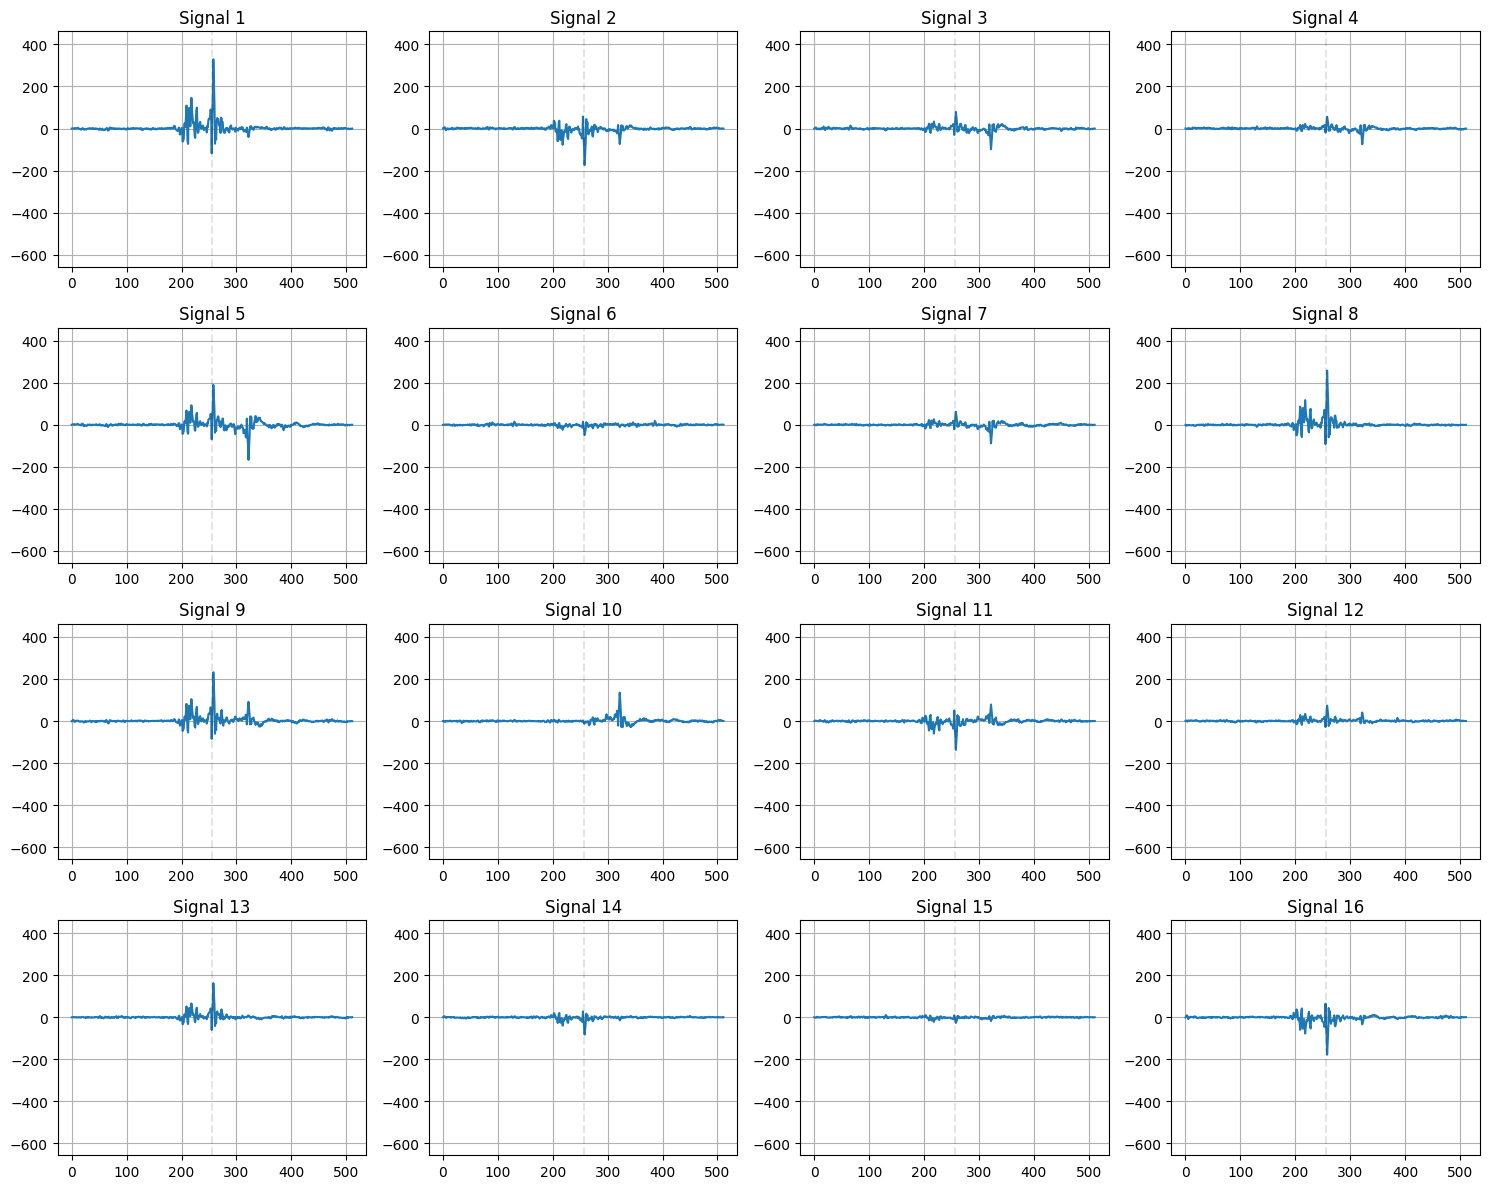

[19/20][0/188]	Loss_D: 1.0439	Loss_G: 4.3720	D(x): 0.1763	D(G(z)): 0.7895 / 0.9120
[19/20][50/188]	Loss_D: 0.7568	Loss_G: 5.9495	D(x): 0.1428	D(G(z)): 0.7347 / 0.8058
[19/20][100/188]	Loss_D: 0.8312	Loss_G: 2.5201	D(x): 0.1655	D(G(z)): 0.6860 / 0.7769
[19/20][150/188]	Loss_D: 0.4759	Loss_G: 2.3968	D(x): 0.0327	D(G(z)): 0.7249 / 0.7953


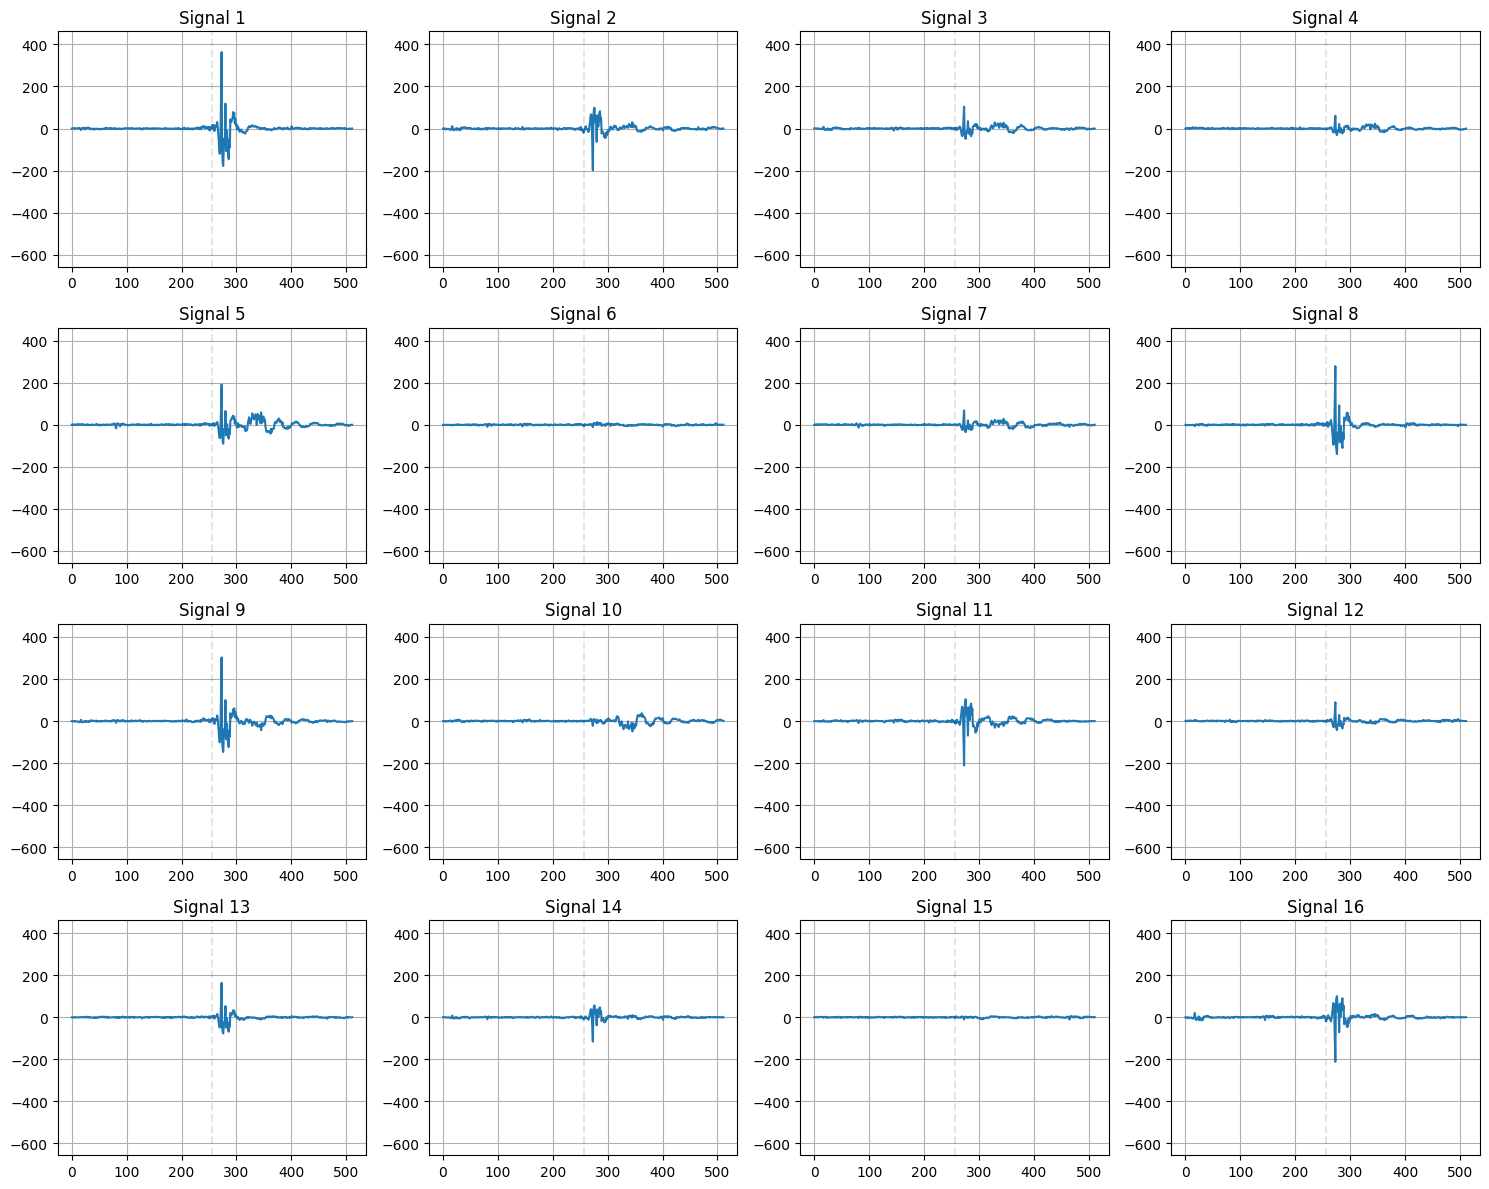

In [60]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
D_gradients = []
G_gradients = []
iters = 0

# label flip probability
flip_p = 1.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_gpu = data.to(device)
        # print(real_gpu.shape)
        b_size = real_gpu.size(0)

        # determine which index of batch to flip on
        flip_mask = torch.rand(b_size) < flip_p

        # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        label = torch.FloatTensor(b_size).uniform_(0.75, 1.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)

        # Forward pass real batch through D
        output = netD(real_gpu).view(-1)
        # print(output)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, device=device)
        # Generate fake signal batch with G
        fake = netG(noise)
        # label.fill_(fake_label)
        label = torch.FloatTensor(b_size).uniform_(0.0, 0.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        # Calculate gradients of discriminator parameters
        D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # label.fill_(real_label)  # fake labels are real for generator cost
        label = torch.FloatTensor(b_size).uniform_(0.75, 1.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Calculate gradients of generator parameters
        G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1 

    
    with torch.no_grad():
        fake_signals = netG(fixed_noise).detach().cpu()
        fig, axes = plt.subplots(4, 4, figsize=(15, 12))

        axes = axes.flatten()

        # plot each signal on a separate subplot
        for i, ax in enumerate(axes):
            x = np.arange(fake_signals.size(dim=2))
            y = fake_signals[i, :, :].flatten()
            y = y * dataset.scaling_factor
            y = y * dataset.std + dataset.mean
            ax.plot(x, y)

            ax.axvline(x=256, color='black', linestyle='--', alpha=0.1)
            ax.set_title(f'Signal {i+1}')
            ax.grid(True)
            ax.set_ylim(common_ylim_signal)

        for i in range(512, 8*4):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_%d.png' % epoch)
        plt.show()
    
    # print(time.time())
    signal_list.append(fake_signals)

### Gradients

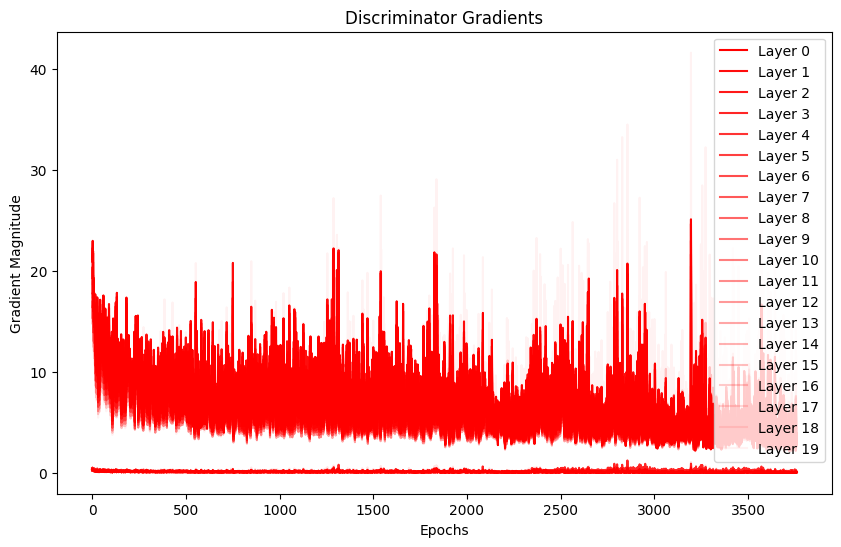

In [61]:
# Get the total number of layers in the discriminator
D_gradients = np.array(D_gradients)
num_layers = D_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(D_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Discriminator Gradients')
plt.legend()
plt.show()

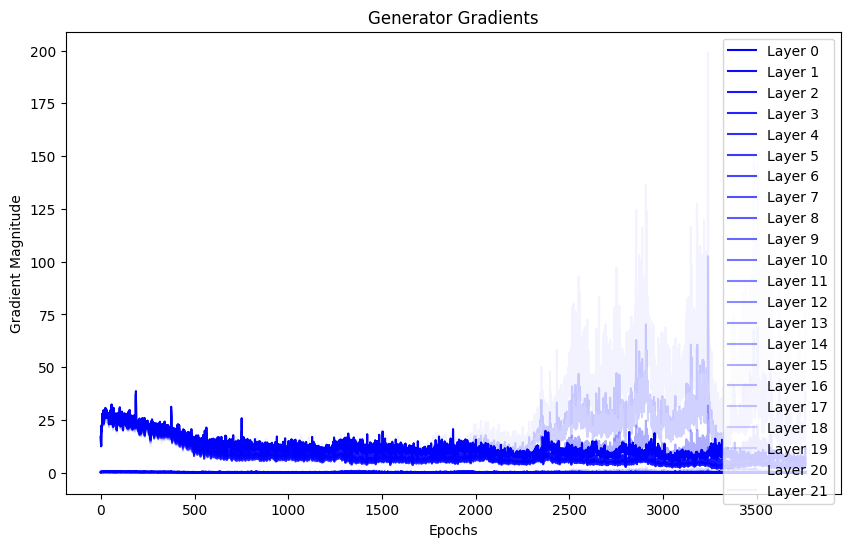

In [62]:
# Get the total number of layers in the discriminator
G_gradients = np.array(G_gradients)
num_layers = G_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(G_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(0, 0, 1, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Generator Gradients')
plt.legend()
plt.show()

### Loss

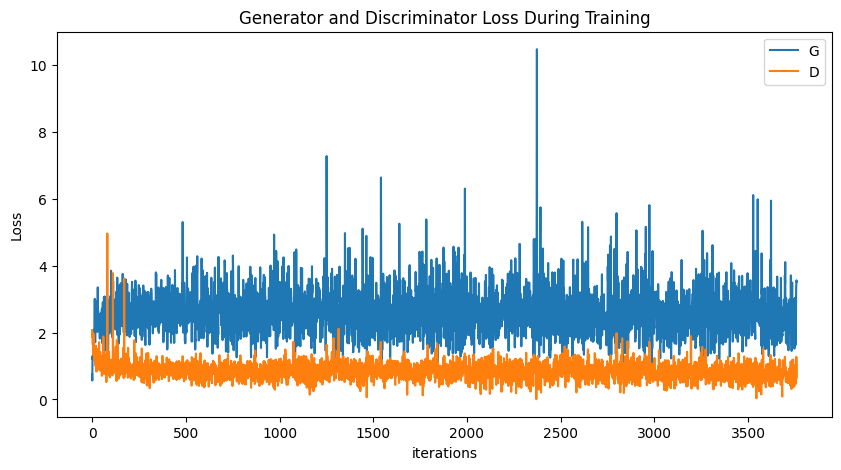

In [63]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generated Signals

torch.Size([32, 1, 512])


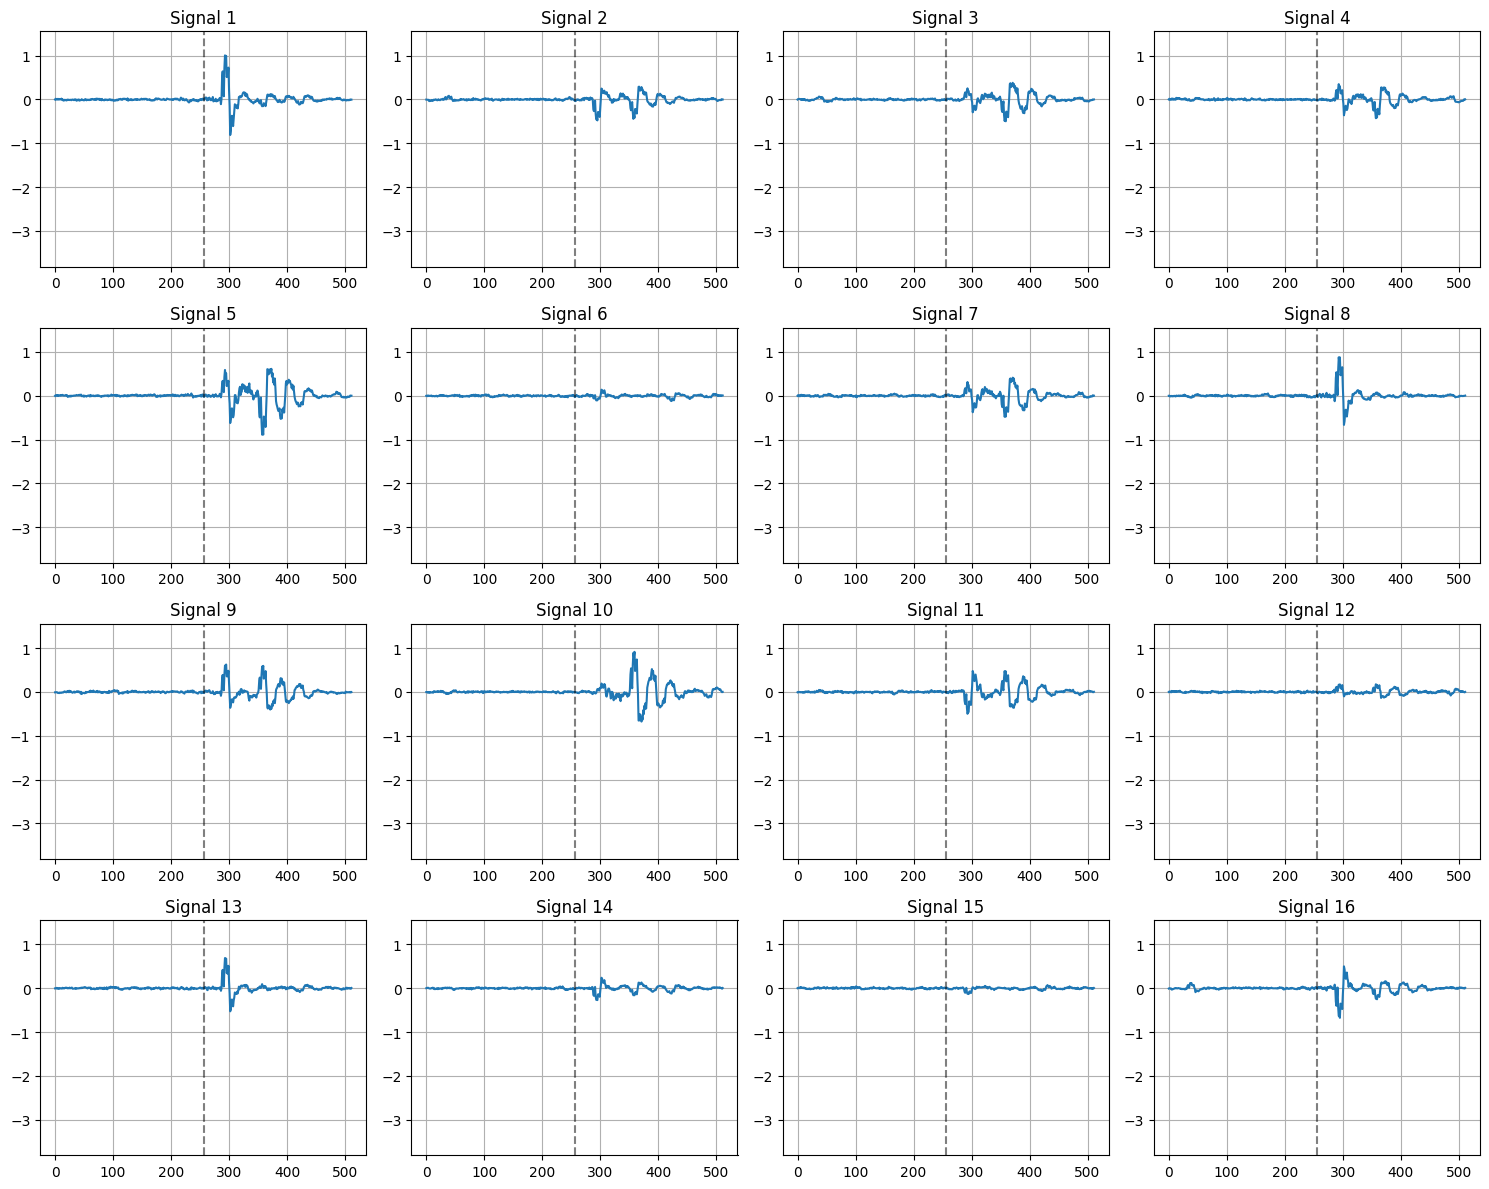

In [64]:
batch = signal_list[16]

# # plotting a single batch
# def plot_waveforms(batch):
#     fig, axs = plt.subplots(8, int(batch_size/8), figsize=(12, 12))
#     axs = axs.ravel()
    
#     for i in range(len(batch)):
#         signal = batch[i].squeeze()
#         axs[i].plot(signal)
#         axs[i].set_title(f'Signal {i+1}')
#         axs[i].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# plot_waveforms(batch)

# Expecting: (32, 1, 512)
print(batch.shape)

# common_ylim = (batch[:,:,:].min(), batch[:,:,:].max())

fig, axes = plt.subplots(4, 4, figsize=(15, 12))

axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(batch.size(dim=2))
    y = batch[i, :, :].flatten()
    ax.plot(x, y)

    ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {i+1}')
    ax.grid(True)
    ax.set_ylim(common_ylim)

for i in range(512, 8*4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../data/gw-dcgans-plots/generated_data.png')
plt.show()

In [65]:
# # Path to the folder containing PNG images
# image_folder = '../data/gw-dcgans-images'

# # Get a list of image filenames in the folder
# image_filenames = sorted([filename for filename in os.listdir(image_folder) if filename.endswith('.png')])

# # Load images and create an animation
# def update(frame):
#     img_path = os.path.join(image_folder, image_filenames[frame])
#     img = Image.open(img_path)
    
#     # Clear the previous plot
#     plt.clf()
    
#     # Display the image without cropping and centered
#     plt.imshow(img, aspect='auto')
#     plt.axis('off')

# fig = plt.figure(figsize=(8, 8))

# # Create the animation
# ani = animation.FuncAnimation(fig, update, frames=len(image_filenames), interval=1000, repeat_delay=1000)

# # Display the animation as HTML (for Jupyter Notebook) or save it to a file
# from IPython.display import HTML
# HTML(ani.to_jshtml())

# Save the animation as an .mp4 video
# output_filename = '../data/gw-dcgans-mp4/signals.mp4'
# ani.save(output_filename, writer='ffmpeg', codec='libx264', fps=8, dpi=100, bitrate=1800)

# print(f'Animation saved as {output_filename}')

In [66]:
# for signal processing
%store signal_list

Stored 'signal_list' (list)
